In [10]:
%matplotlib inline

import json
import os
from copy import deepcopy

import kerastuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import silence_tensorflow.auto
from barplots import barplots
from epigenomic_dataset import (
    active_enhancers_vs_inactive_enhancers,
    active_promoters_vs_inactive_promoters,
    active_enhancers_vs_active_promoters
)
from kerastuner import Hyperband
from matplotlib.colors import ListedColormap
from minepy import MINE
from multiprocessing import cpu_count
from plot_keras_history import plot_history
from scipy.stats import entropy, pearsonr, spearmanr, wilcoxon
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook
from ucsc_genomes_downloader import Genome

from bioproject.data_processing import (
    fill_data_dictionaries, get_class_weights, get_cnn_sequence,
    get_ffnn_sequence, get_mmnn_sequence, missing_values_report
)
from bioproject.model_evaluation import repeated_holdout_evaluation
from bioproject.models import (
    build_cnn_iwbbio2020, build_cnn1d, build_cnn1d_hp, 
    build_decode, build_deep_enhancer, build_deepcape, 
    build_ffnn, build_ffnn_hp, build_ffnn_iwbbio2020, 
    build_mmnn, build_cnn1d_hp_support
)

# Data retrieval

In [3]:
genome = Genome("hg38")
cell_line = "HepG2"
window_size = 256
beds, epigenomes, labels, sequences = dict(), dict(), dict(), dict()

In [4]:
for (task, region) in tqdm_notebook(
    (
        (active_enhancers_vs_inactive_enhancers, "enhancers"),
        (active_promoters_vs_inactive_promoters, "promoters")
    ),
    desc="Retrieving task data",
    leave=False
):
    beds, epigenomes, labels, sequences = fill_data_dictionaries(
        task=task, 
        region=region,
        genome=genome, 
        beds=beds, 
        epigenomes=epigenomes,
        labels=labels,
        sequences=sequences, 
        cell_line=cell_line, 
        window_size=window_size
    )

In [4]:
# Deep copies of the dictionaries for analysis purposes
beds_c = deepcopy(beds)
epigenomes_c = deepcopy(epigenomes)
labels_c = deepcopy(labels) 
sequences_c = deepcopy(sequences)

# Data elaboration

## Missing values

In [5]:
missing_values_report(epigenomes_c, beds_c, genome)

ENHANCERS EPIGENOMIC DATA
The dataset contains 19 NaN values out of 35566170 total values.
Sample (row) number 4934 has the most NaN values, amounting to 1 NaN values out of 562 row values.
Feature (column) number 161 (whole-genome shotgun bisulfite sequencing) has the most NaN values, amounting to 19 NaN values out of 63285 column values.

PROMOTERS EPIGENOMIC DATA
The dataset contains 359 NaN values out of 56133122 total values.
Sample (row) number 46781 has the most NaN values, amounting to 12 NaN values out of 562 row values.
Feature (column) number 161 (whole-genome shotgun bisulfite sequencing) has the most NaN values, amounting to 138 NaN values out of 99881 column values.

ENHANCERS SEQUENCE DATA
The dataset contains 1 unidentified nucleotides.
PROMOTERS SEQUENCE DATA
The dataset contains 4 unidentified nucleotides.


Imputation for dataset analysis only.

In [6]:
for region, epigenome in epigenomes_c.items():
    epigenomes_c[region] = pd.DataFrame(
        KNNImputer(n_neighbors=5).fit_transform(epigenome.values),
        columns=epigenome.columns,
        index=epigenome.index
    )

## Rate between features and samples

In [7]:
for region, epigenome in epigenomes_c.items():
    print(
        f"The rate between features and samples "
        f"for {region} data is: {epigenome.shape[0]/epigenome.shape[1]}"
    )

The rate between features and samples for enhancers data is: 112.6067615658363
The rate between features and samples for promoters data is: 177.72419928825622


## Class balance

<ipython-input-8-721bac88092f>:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


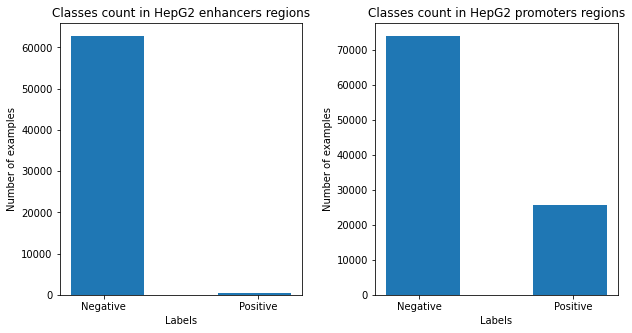

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for ax, (region, y) in zip(axes.ravel(), labels_c.items()):
    y.hist(ax=ax, bins=3)
    ax.set(
        xlabel="Labels", 
        ylabel="Number of examples",
        title=f"Classes count in {cell_line} {region} regions"
    )
    ax.grid(False)
    ax.set_xticks([0.15, 0.85])
    ax.set_xticklabels(["Negative", "Positive"])

fig.savefig(f"classes_count.png")
fig.show()

In [9]:
for (region, y) in labels_c.items():
    print(region.upper())
    display(y.value_counts(normalize=True))

ENHANCERS


0    0.992036
1    0.007964
dtype: float64

PROMOTERS


0    0.741873
1    0.258127
dtype: float64

## Constant features

In [10]:
def drop_constant_features(df: pd.DataFrame) -> pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

for region, epigenome in epigenomes_c.items():
    result = drop_constant_features(epigenome)
    if epigenome.shape[1] != result.shape[1]:
        print(f"Found constant features in {region}.")
        epigenomes_c[region] = result
    else:
        print(f"No constant features were found in {region}.")

No constant features were found in enhancers.
No constant features were found in promoters.


# Data correlations and distributions

Scaling for dataset analysis only.

In [11]:
for region, epigenome in epigenomes_c.items():
    epigenomes_c[region] = pd.DataFrame(
        RobustScaler().fit_transform(epigenome.values),
        columns=epigenome.columns,
        index=epigenome.index
    )

## Correlation with output

In [12]:
p_value_threshold = 0.01
correlation_threshold = 0.05


uncorrelated = {
    region: set()
    for region in epigenomes_c
}

### Pearson correlation coefficient (linear correlation)

In [13]:
for region, epigenome in epigenomes_c.items():
    for column in tqdm_notebook(
        epigenome.columns,
        desc=f"Running Pearson test for {region}", 
        dynamic_ncols=True, 
        leave=False
    ):
        correlation, p_value = pearsonr(
            epigenome[column].values.ravel(),
            labels_c[region].values.ravel()
        )
        if p_value > p_value_threshold:
            print(f"{region} uncorrelated: ", column, correlation)
            uncorrelated[region].add(column)

enhancers uncorrelated:  ZNF382 -0.004740632961373928
enhancers uncorrelated:  SNRNP70 -0.006954472253379358
enhancers uncorrelated:  NBN 0.0002577522634270317
enhancers uncorrelated:  ARNT 0.0032427807506031107
enhancers uncorrelated:  ATM 0.0003747189834153468


### Spearman correlation coefficient (monotonic correlation)

In [14]:
for region, epigenome in epigenomes_c.items():
    for column in tqdm_notebook(
        epigenome.columns,
        desc=f"Running Spearman test for {region}", 
        dynamic_ncols=True, 
        leave=False
    ):
        correlation, p_value = spearmanr(
            epigenome[column].values.ravel(),
            labels_c[region].values.ravel()
        )
        if p_value > p_value_threshold:
            print(f"{region} uncorrelated: ", column, correlation)
            uncorrelated[region].add(column)

enhancers uncorrelated:  CEBPZ 0.00346667742298945
enhancers uncorrelated:  ZNF382 -0.00048537028798314183
enhancers uncorrelated:  EZH2 -0.008446204181030554
enhancers uncorrelated:  MAFG 0.009433509129308454
enhancers uncorrelated:  SNRNP70 -0.007873702306948163
enhancers uncorrelated:  NBN 0.0014486061073292482
enhancers uncorrelated:  ARNT 0.0027246360897861754
enhancers uncorrelated:  ATM -0.004740021693557217


promoters uncorrelated:  ZNF207 0.006914714963179927
promoters uncorrelated:  ZNF737 -0.0075056386989746544


### Maximal information coefficient

In [15]:
for region, epigenome in epigenomes_c.items():
    for column in tqdm_notebook(
        uncorrelated[region], 
        desc=f"Running MINE test for {region}", 
        dynamic_ncols=True, 
        leave=False
    ):
        mine = MINE()
        mine.compute_score(
            epigenome[column].values.ravel(),
            labels_c[region].values.ravel()
        )
        score = mine.mic()

        if score < correlation_threshold:
            print(f"{region} uncorrelated: ", column, score)
        else:
            uncorrelated[region].remove(column)

<ipython-input-15-06eacc1b77f1>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mine.compute_score(


enhancers uncorrelated:  MAFG 0.004653394281025564
enhancers uncorrelated:  SNRNP70 0.003719167213015619
enhancers uncorrelated:  EZH2 0.004463926606996195
enhancers uncorrelated:  NBN 0.002344091430543024
enhancers uncorrelated:  ZNF382 0.0020626663069754415
enhancers uncorrelated:  CEBPZ 0.0031235499700166037
enhancers uncorrelated:  ARNT 0.0029859139216655084
enhancers uncorrelated:  ATM 0.0037158411439976715


promoters uncorrelated:  ZNF207 0.00530210440912936
promoters uncorrelated:  ZNF737 0.013554544893407116


### Dropping features uncorrelated with output

In [16]:
print(uncorrelated)

{'enhancers': {'MAFG', 'SNRNP70', 'EZH2', 'NBN', 'ZNF382', 'CEBPZ', 'ARNT', 'ATM'}, 'promoters': {'ZNF207', 'ZNF737'}}


In [17]:
for region, epigenome in epigenomes_c.items():
    epigenomes_c[region] = epigenome.drop(
        columns=[
            col
            for col in uncorrelated[region]
            if col in epigenome.columns
        ]
    )

## Features correlation

In [18]:
p_value_threshold = 0.01
correlation_threshold = 0.95

In [19]:
extremely_correlated = {
    region: set()
    for region in epigenomes_c
}

scores = {
    region: []
    for region in epigenomes_c
}

for region, epigenome in epigenomes_c.items():
    for i, column in tqdm_notebook(
        enumerate(epigenome.columns),
        total=len(epigenome.columns),
        desc=f"Running Pearson test for {region}",
        dynamic_ncols=True,
        leave=False
    ):
        for feature in epigenome.columns[i+1:]:
            correlation, p_value = pearsonr(
                epigenome[column].values.ravel(),
                epigenome[feature].values.ravel()
            )
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))

            if p_value < p_value_threshold \
                    and correlation > correlation_threshold:
                print(
                    f"{region} extremely correlated: ", 
                    column, feature, correlation
                )
                if entropy(epigenome[column]) > entropy(epigenome[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

enhancers extremely correlated:  SOX13 SOX5 0.9567474565697234
enhancers extremely correlated:  SAP130 ARID4B 0.9534193841276725


promoters extremely correlated:  ZNF580 ERF 0.9578129785007484
promoters extremely correlated:  ZBTB25 ZNF639 0.9553346670101738
promoters extremely correlated:  KLF16 ZGPAT 0.9520685292986377
promoters extremely correlated:  KLF16 ERF 0.9523010352412413
promoters extremely correlated:  ZNF274 ZNF883 0.9565026558276916
promoters extremely correlated:  SAP130 ARID4B 0.9727426287573443
promoters extremely correlated:  ZNF407 ZNF883 0.9515272947230262
promoters extremely correlated:  NFYB NFYC 0.9577113198292331


In [20]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

Most correlated features from enhancers epigenome.


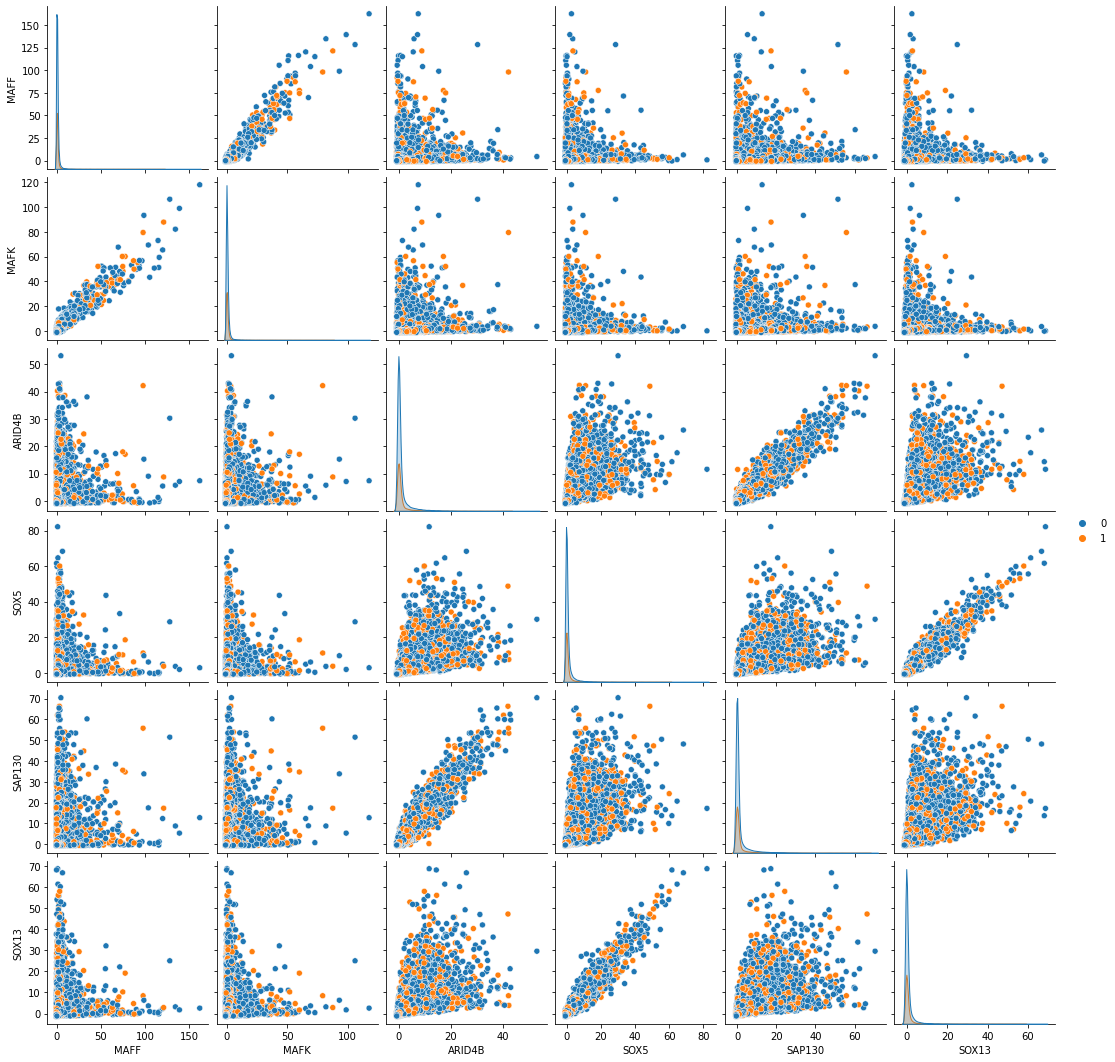

Most correlated features from promoters epigenome.


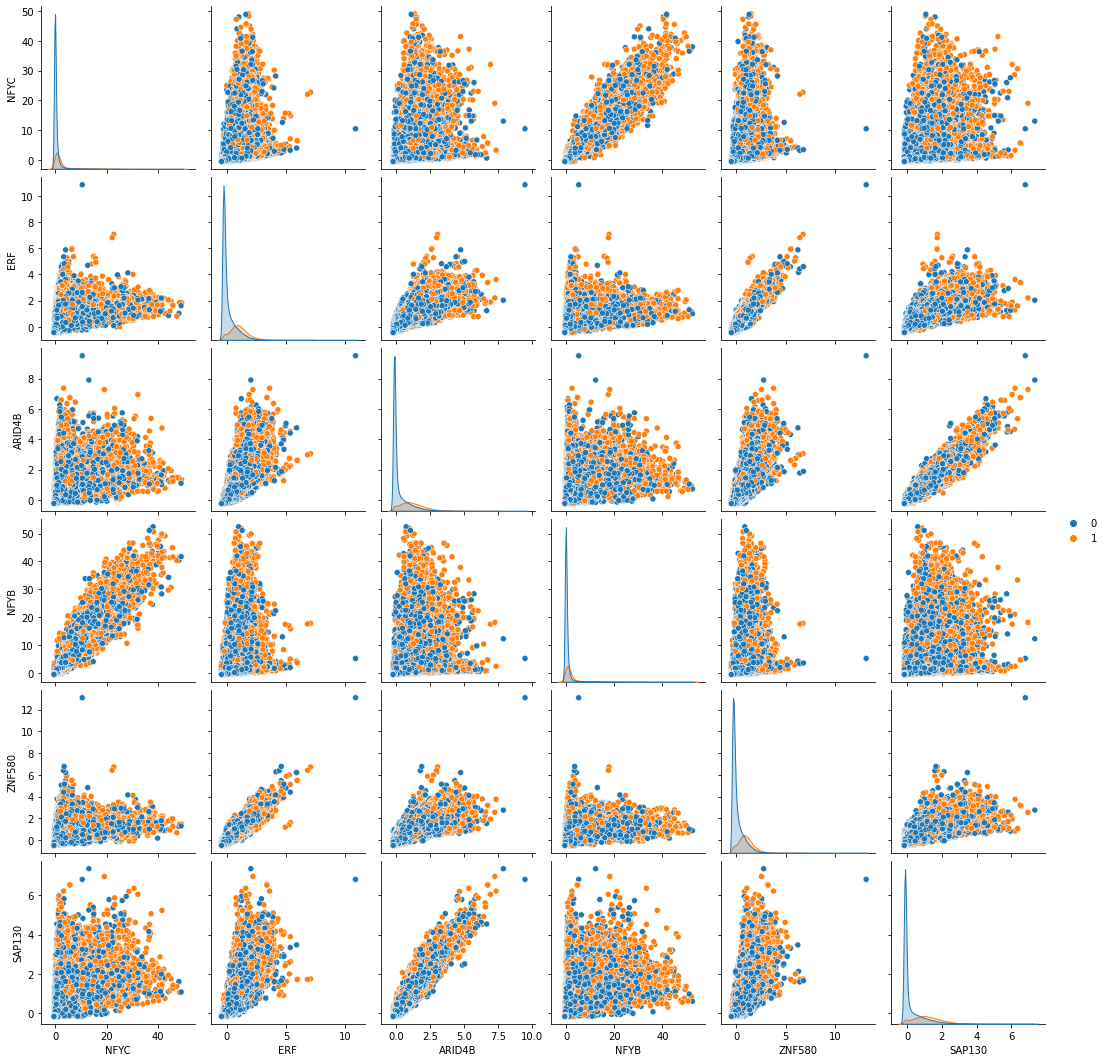

In [21]:
for region, epigenome in epigenomes_c.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenome.")
    sns_plot = sns.pairplot(
        pd.concat([epigenome[columns], y], axis=1),
        hue=y.columns[0]
    )
    sns_plot.savefig(f"most_correlated_features_{region}.png")
    plt.show()

## Features distributions

Top 5 different features from enhancers.


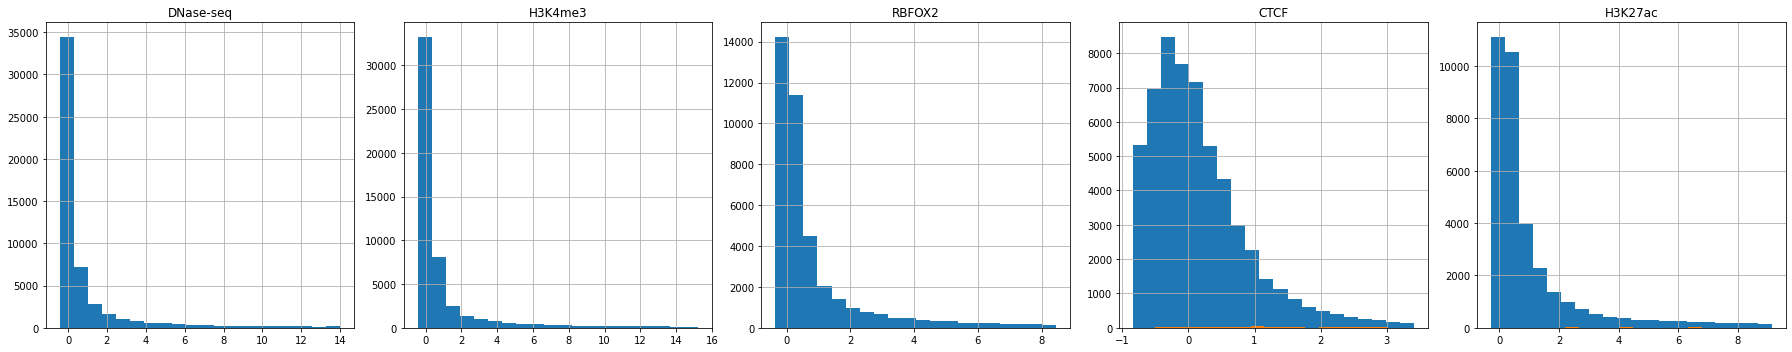

Top 5 different features from promoters.


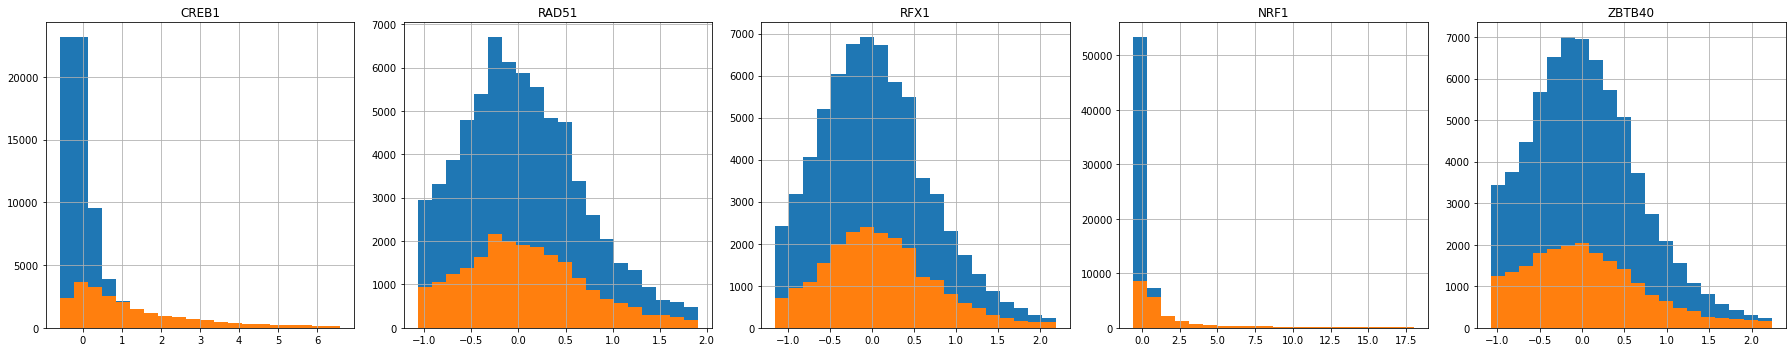

In [24]:
def get_top_most_different(distances, n:int):
    return np.argsort(-np.mean(distances, axis=1).flatten())[:n]

top_number = 5

for region, epigenome in epigenomes_c.items():
    dist = euclidean_distances(epigenome.T)
    most_distant_columns_indices = get_top_most_different(dist, top_number)
    columns = epigenome.columns[most_distant_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = epigenome[column].quantile(
            [0.05, 0.95]
        ).values.ravel()

        mask = (
            (epigenome[column] < tail) & (epigenome[column] > head)
        ).values

        cleared_x = epigenome[column][mask]
        cleared_y = labels_c[region].values.ravel()[mask]

        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column)
    fig.tight_layout()
    fig.savefig(f"top_different_features_{region}.png")

    plt.show()

Top 5 different tuples of features from enhancers.


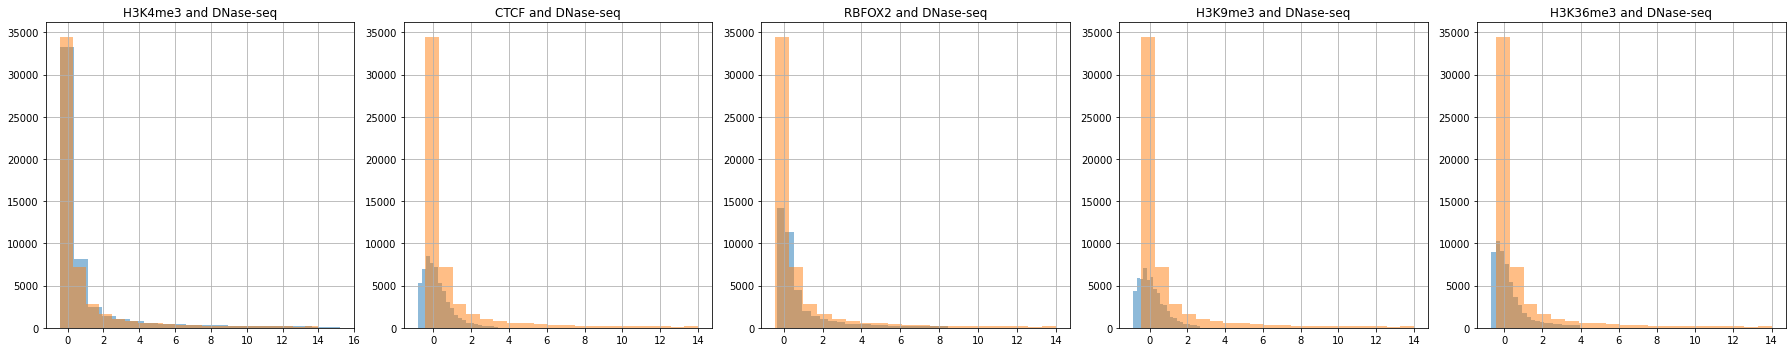

Top 5 different tuples of features from promoters.


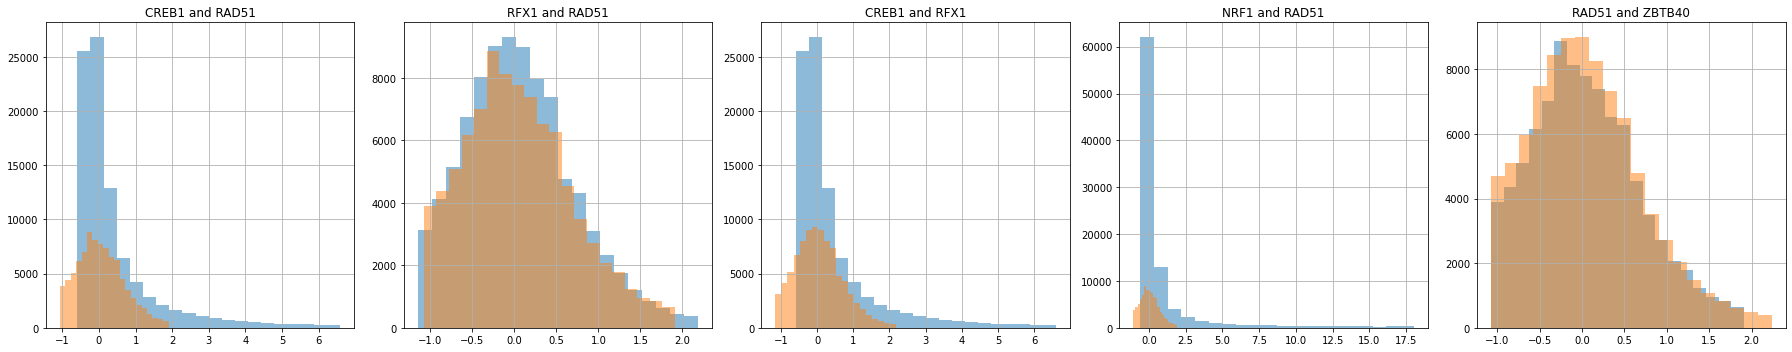

In [25]:
def get_top_most_different_tuples(distances, n:int):
    return list(
        zip(
            *np.unravel_index(
                np.argsort(-distances.ravel()), distances.shape
            )
        )
    )[:n]

top_number = 5

for region, epigenome in epigenomes_c.items():
    dist = euclidean_distances(epigenome.T)
    dist = np.triu(dist)
    tuples = get_top_most_different_tuples(dist, top_number)
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different tuples of features from {region}.")
    for (i, j), axis in zip(tuples, axes.flatten()):
        column_i = epigenome.columns[i]
        column_j = epigenome.columns[j]
        for column in (column_i, column_j):
            head, tail = epigenome[column].quantile([0.05, 0.95]).values.ravel()
            mask = (
                    (epigenome[column] < tail) & (epigenome[column] > head)
            ).values
            epigenome[column][mask].hist(ax=axis, bins=20, alpha=0.5)
        axis.set_title(f"{column_i} and {column_j}")
    fig.tight_layout()
    fig.savefig(f"top_different_tuples_{region}.png")

    plt.show()

# Data visualization

In [26]:
epigenomes_c = deepcopy(epigenomes)
sequences_c = deepcopy(sequences)

for region, epigenome in epigenomes_c.items():
    epigenomes_c[region] = pd.DataFrame(
        KNNImputer(n_neighbors=5).fit_transform(epigenome.values),
        columns=epigenome.columns,
        index=epigenome.index
    )

for region, epigenome in epigenomes_c.items():
    epigenomes_c[region] = pd.DataFrame(
        RobustScaler().fit_transform(epigenome.values),
        columns=epigenome.columns,
        index=epigenome.index
    )

In [27]:
tasks = {
    "x":[
        *[
            val.values
            for val in epigenomes_c.values()
        ],
        *[
            val.values
            for val in sequences_c.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels_c.values()
        ],
        *[
            val.values.ravel()
            for val in labels_c.values()
        ]
    ],
    "titles":[
        "Epigenomes enhancers",
        "Epigenomes promoters",
        "Sequences enhancers",
        "Sequences promoters"
    ]
}

xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]
colors = np.array([
    "tab:blue",
    "tab:orange",
])

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

## PCA

In [28]:
def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)

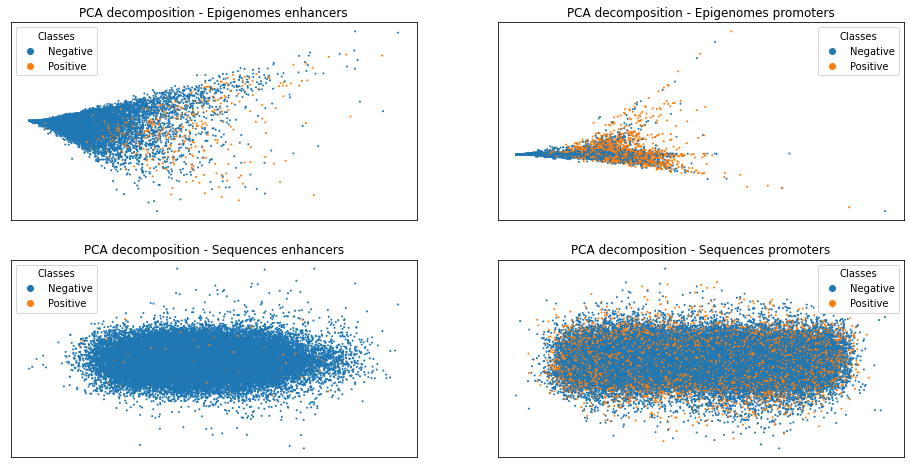

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

for x, y, title, axis in tqdm_notebook(
    zip(xs, ys, titles, axes.flatten()), 
    desc="Computing PCAs", 
    total=len(xs),
    leave=False
):
    scatter = axis.scatter(
        *pca(x).T,
        s=1,
        c=y,
        cmap=ListedColormap(["tab:blue", "tab:orange"])
    )
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
    axis.legend(
        title="Classes",
        handles=scatter.legend_elements()[0], 
        labels=["Negative", "Positive"]
    )

fig.savefig("pca.png")    
plt.show()

## TSNE

In [32]:
from MulticoreTSNE import MulticoreTSNE as UTSNE

def ulyanov_tsne(
    x: np.ndarray, 
    perplexity: int, 
    dimensionality_threshold: int = 50, 
    n_components: int = 2
):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return UTSNE(
        n_components=n_components, 
        perplexity=perplexity, 
        n_jobs=cpu_count(), 
        random_state=42, 
        verbose=True
    ).fit_transform(x)

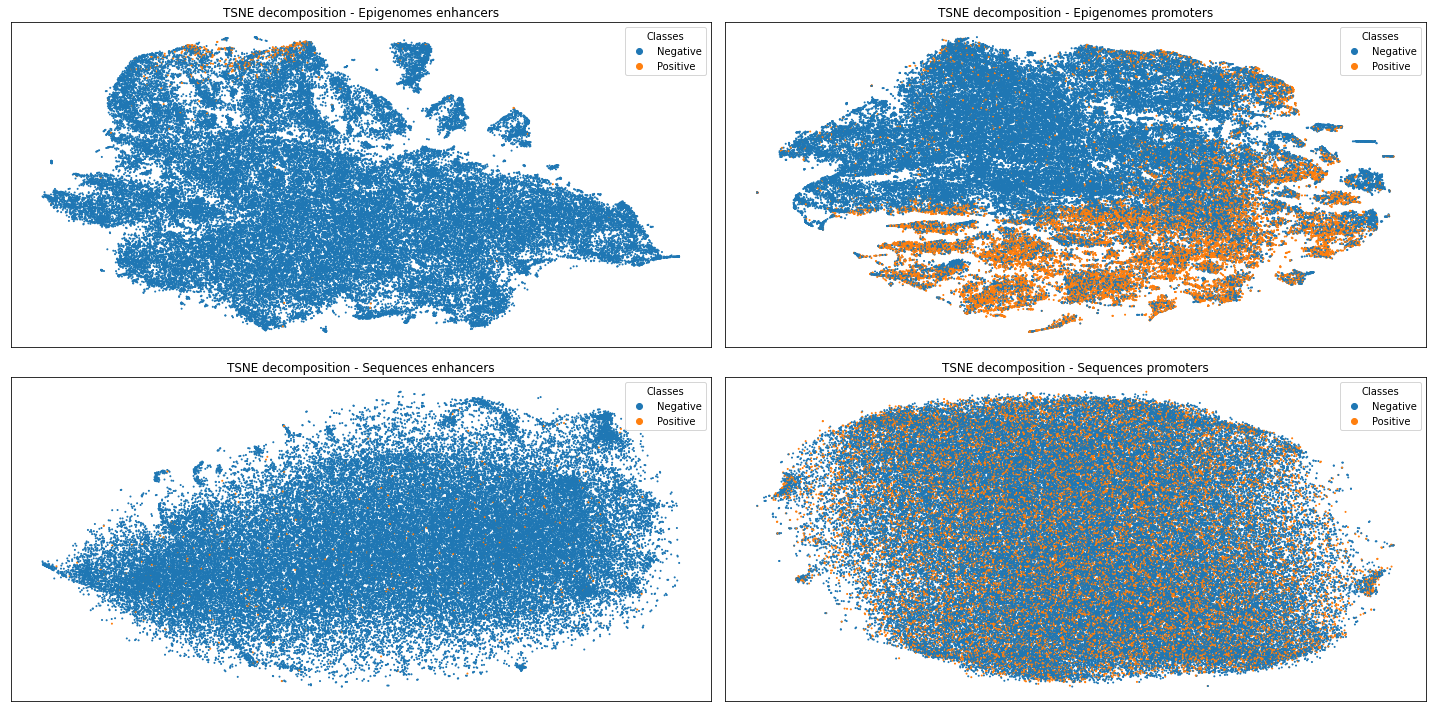

In [33]:
for perplexity in tqdm_notebook(
    (50, ), 
    desc="Running perplexities",
    leave=False
):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    for x, y, title, axis in tqdm_notebook(
        zip(xs, ys, titles, axes.flatten()), 
        desc="Computing TSNEs", 
        total=len(xs),
        leave=False
    ):
        scatter = axis.scatter(
            *ulyanov_tsne(x, perplexity=perplexity).T, 
            s=1, 
            c=y,
            cmap=ListedColormap(["tab:blue", "tab:orange"])
        )
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_title(f"TSNE decomposition - {title}")
        axis.legend(
            title="Classes",
            handles=scatter.legend_elements()[0], 
            labels=["Negative", "Positive"]
        )
    fig.savefig(f"{perplexity}_tsne.png")    
    fig.tight_layout()
    plt.show()

# Models evaluation

In [12]:
def get_sklearn_sequence(X, y):
    return {"X": X, "y": y}

In [13]:
def get_optimized_cnn1d(
    window_size, 
    holdout_number, 
    genome, 
    bed_train, 
    bed_valid,
    X_train,
    X_valid,
    y_train, 
    y_valid,
    region,
    mmnn_models
):
    """Return CNN model resulting from hyperparameter optimization.
    If the best hyperparemeters are saved on file, build model from
    file.
    """
    
    filename = f"cnn1d_hp_{holdout_number}_{region}"
    
    if os.path.isfile("hp_params/" + filename + ".json"):
        with open("hp_params/" + filename + ".json") as f:
            results = json.load(f)
            return build_cnn1d_hp_support(
                window_size,
                **results
            )
    
    tuner = Hyperband(
        lambda hp: build_cnn1d_hp(window_size, hp),
        objective=kt.Objective("val_AUPRC", direction="max"),
        max_epochs=15,
        factor=3,
        directory="tuner",
        project_name=filename,
        # overwrite=True
    )
    
    tuner.search(
        get_cnn_sequence(genome, bed_train, y_train),
        validation_data=get_cnn_sequence(genome, bed_valid, y_valid),
        epochs=200,
        batch_size=256,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    
    results = {
        "num_conv_layers": best_hps.get("num_conv_layers"),
        "n_neurons0": best_hps.get("n_neurons0"),
        "kernel_size0": best_hps.get("kernel_size0"),
        "drop_rate": best_hps.get("drop_rate"),
        "learning_rate": best_hps.get("learning_rate"),
        "n_neurons1": best_hps.get("n_neurons1") if best_hps.get("num_conv_layers") >= 3 else None,
        "kernel_size1": best_hps.get("kernel_size1") if best_hps.get("num_conv_layers") >= 3 else None
    }
    
    with open("hp_params/" + filename + ".json", "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    model= tuner.hypermodel.build(best_hps)
    return {"model": model}

In [14]:
def get_optimized_ffnn(
    window_size, 
    holdout_number, 
    genome, 
    bed_train, 
    bed_valid,
    X_train,
    X_valid,
    y_train, 
    y_valid,
    region,
    mmnn_models
):
    """Return FFNN model resulting from hyperparameter optimization.
    If the best hyperparemeters are saved on file, build model from
    file.
    """
    
    filename = f"ffnn_hp_{holdout_number}_{region}"
    
    if os.path.isfile("hp_params/" + filename + ".json"):
        with open("hp_params/" + filename + ".json") as f:
            results = json.load(f)
            return build_ffnn(
                X_train,
                **results
            )
    
    tuner = Hyperband(
        lambda hp: build_ffnn_hp(X_train, hp),
        objective=kt.Objective("val_AUPRC", direction="max"),
        max_epochs=15,
        factor=3,
        directory="tuner",
        project_name=filename,
        # overwrite=True
    )
    
    tuner.search(
        get_ffnn_sequence(X_train, y_train),
        validation_data=get_ffnn_sequence(X_valid, y_valid),
        epochs=200,
        batch_size=256,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    
    results = {
        "num_layers": best_hps.get("num_layers"),
        "n_neurons0": best_hps.get("n_neurons0"),
        "l2_reg": best_hps.get("l2_reg"),
        "learning_rate": best_hps.get("learning_rate"),
        "n_neurons1": best_hps.get("n_neurons1") if best_hps.get("num_layers") >= 3 else None,
    }
    
    with open("hp_params/" + filename + ".json", "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    model= tuner.hypermodel.build(best_hps)
    return {"model": model}

In [17]:
models = {
    "ffnn": (
        lambda X_train, window_size, kwargs: build_ffnn(X_train),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y
        ),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "ffnn_hp": (
        lambda X_train, window_size, kwargs: get_optimized_ffnn(
            window_size=window_size,
            X_train=X_train,
            **kwargs
        ),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y
        ),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "cnn1d": (
        lambda X_train, window_size, kwargs: build_cnn1d(window_size),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "cnn1d_os": (
        lambda X_train, window_size, kwargs: build_cnn1d(window_size),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y, resampling_strategy="over_sample"
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        {
            "enhancers": {
                "resampling_strategy": "over_sample"
            }, 
            "promoters": {
                "resampling_strategy": "over_sample"
            }
        }
    ),
    "cnn1d_us": (
        lambda X_train, window_size, kwargs: build_cnn1d(window_size),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y, resampling_strategy="under_sample"
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        {
            "enhancers": {
                "resampling_strategy": "under_sample"
            }, 
            "promoters": {
                "resampling_strategy": "under_sample"
            }
        }
    ),
    "cnn1d_hp": (
        lambda X_train, window_size, kwargs: get_optimized_cnn1d(
            window_size=window_size,
            X_train=X_train,
            **kwargs
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "mmnn": (
        lambda X_train, window_size, kwargs: build_mmnn(
            X_train, window_size
        ),
        lambda genome, bed, X, y: get_mmnn_sequence(
            genome, bed, X, y
        ),
        lambda genome, bed, X, y: get_mmnn_sequence(
            genome, bed, X, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "mmnn_cw": (
        lambda X_train, window_size, kwargs: build_mmnn(
            X_train, window_size
        ),
        lambda genome, bed, X, y: get_mmnn_sequence(
            genome, bed, X, y
        ),
        lambda genome, bed, X, y: get_mmnn_sequence(
            genome, bed, X, y
        ),
        {
            "enhancers": {
                "class_weight": get_class_weights(labels["enhancers"])
            }, 
            "promoters": {
                "class_weight": get_class_weights(labels["promoters"])
            }
        }
    ),
    "mmnn_pre": (
        lambda X_train, window_size, kwargs: build_mmnn(
            X_train, window_size, pretrained=True, 
            ffnn_model_name="ffnn",
            cnn_model_name="cnn1d",
            **kwargs
        ),
        lambda genome, bed, X, y: get_mmnn_sequence(
            genome, bed, X, y
        ),
        lambda genome, bed, X, y: get_mmnn_sequence(
            genome, bed, X, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "bayesian_ffnn": (
        lambda X_train, window_size, kwargs: build_ffnn_iwbbio2020(X_train),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y, batch_size=100
        ),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y, batch_size=100
        ),
        {
            "enhancers": {"batch_size": 100}, 
            "promoters": {"batch_size": 100}
        }
    ),
    "bayesian_cnn": (
        lambda X_train, window_size, kwargs: build_cnn_iwbbio2020(window_size),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y, batch_size=100
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y, batch_size=100
        ),
        {
            "enhancers": {"batch_size": 100}, 
            "promoters": {"batch_size": 100}
        }
    ),
    "deep_enhancer": (
        lambda X_train, window_size, kwargs: build_deep_enhancer(window_size),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y
        ),
        {"enhancers": {}, "promoters": {}}
    ),
    "deepcape": (
        lambda X_train, window_size, kwargs: build_deepcape(window_size),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y, batch_size=128
        ),
        lambda genome, bed, X, y: get_cnn_sequence(
            genome, bed, y, batch_size=128
        ),
        {
            "enhancers": {"batch_size": 128}, 
            "promoters": {"batch_size": 128}
        }
    ),
    "decode": (
        lambda X_train, window_size, kwargs: build_decode(X_train),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y, batch_size=32
        ),
        lambda genome, bed, X, y: get_ffnn_sequence(
            X, y, batch_size=32
        ),
        {
            "enhancers": {
                "batch_size": 32, 
                "patience": 2,
                "class_weight": get_class_weights(labels["enhancers"])
            }, 
            "promoters": {
                "batch_size": 32, 
                "patience": 2,
                "class_weight": get_class_weights(labels["promoters"])
            }
        }
    ),
    "random_forest": (
        lambda X_train, window_size, kwargs: {
            "model": RandomForestClassifier(
                n_estimators=600,
                class_weight="balanced_subsample",
                max_depth=5,
                min_samples_leaf=100,
                n_jobs=cpu_count(),
                verbose=False
            )
        },
        lambda genome, bed, X, y: get_sklearn_sequence(X, y),
        lambda genome, bed, X, y: get_sklearn_sequence(X, y),
        {"enhancers": {}, "promoters": {}}
    )
}

In [ ]:
results = dict()

for region in ("enhancers", "promoters"):
    results[region] = dict()
    
    histories, performances, kept_f, discarded_f = repeated_holdout_evaluation(
        X_epi=epigenomes[region],
        bed=beds[region],
        y=labels[region],
        genome=genome,
        region=region,
        models=models,
        window_size=window_size,
        n_splits=10
    )
    
    results[region]["histories"] = histories
    results[region]["performances"] = performances
    results[region]["kept"] = kept_f
    results[region]["discarded"] = discarded_f

In [7]:
pd.concat(results["enhancers"]["performances"]).to_csv("enhancers_results.csv")
pd.concat(results["promoters"]["performances"]).to_csv("promoters_results.csv")

(<Figure size 1440x2520 with 28 Axes>,
 array([[<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
         <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
         <AxesSubplot:title={'center':'Recall'}, xlabel='Epochs', ylabel='Recall'>,
         <AxesSubplot:title={'center':'Precision'}, xlabel='Epochs', ylabel='Precision'>],
        [<AxesSubplot:title={'center':'AUROC'}, xlabel='Epochs', ylabel='AUROC'>,
         <AxesSubplot:title={'center':'AUPRC'}, xlabel='Epochs', ylabel='AUPRC'>,
         <AxesSubplot:title={'center':'F1 Score'}, xlabel='Epochs', ylabel='F1 Score'>,
         <AxesSubplot:title={'center':'Balanced Accuracy'}, xlabel='Epochs', ylabel='Balanced Accuracy'>],
        [<AxesSubplot:title={'center':'Specificity'}, xlabel='Epochs', ylabel='Specificity'>,
         <AxesSubplot:title={'center':'Miss rate'}, xlabel='Epochs', ylabel='Miss rate'>,
         <AxesSubplot:title={'center':'Fall out'}, xlabel='Epochs', ylabel=

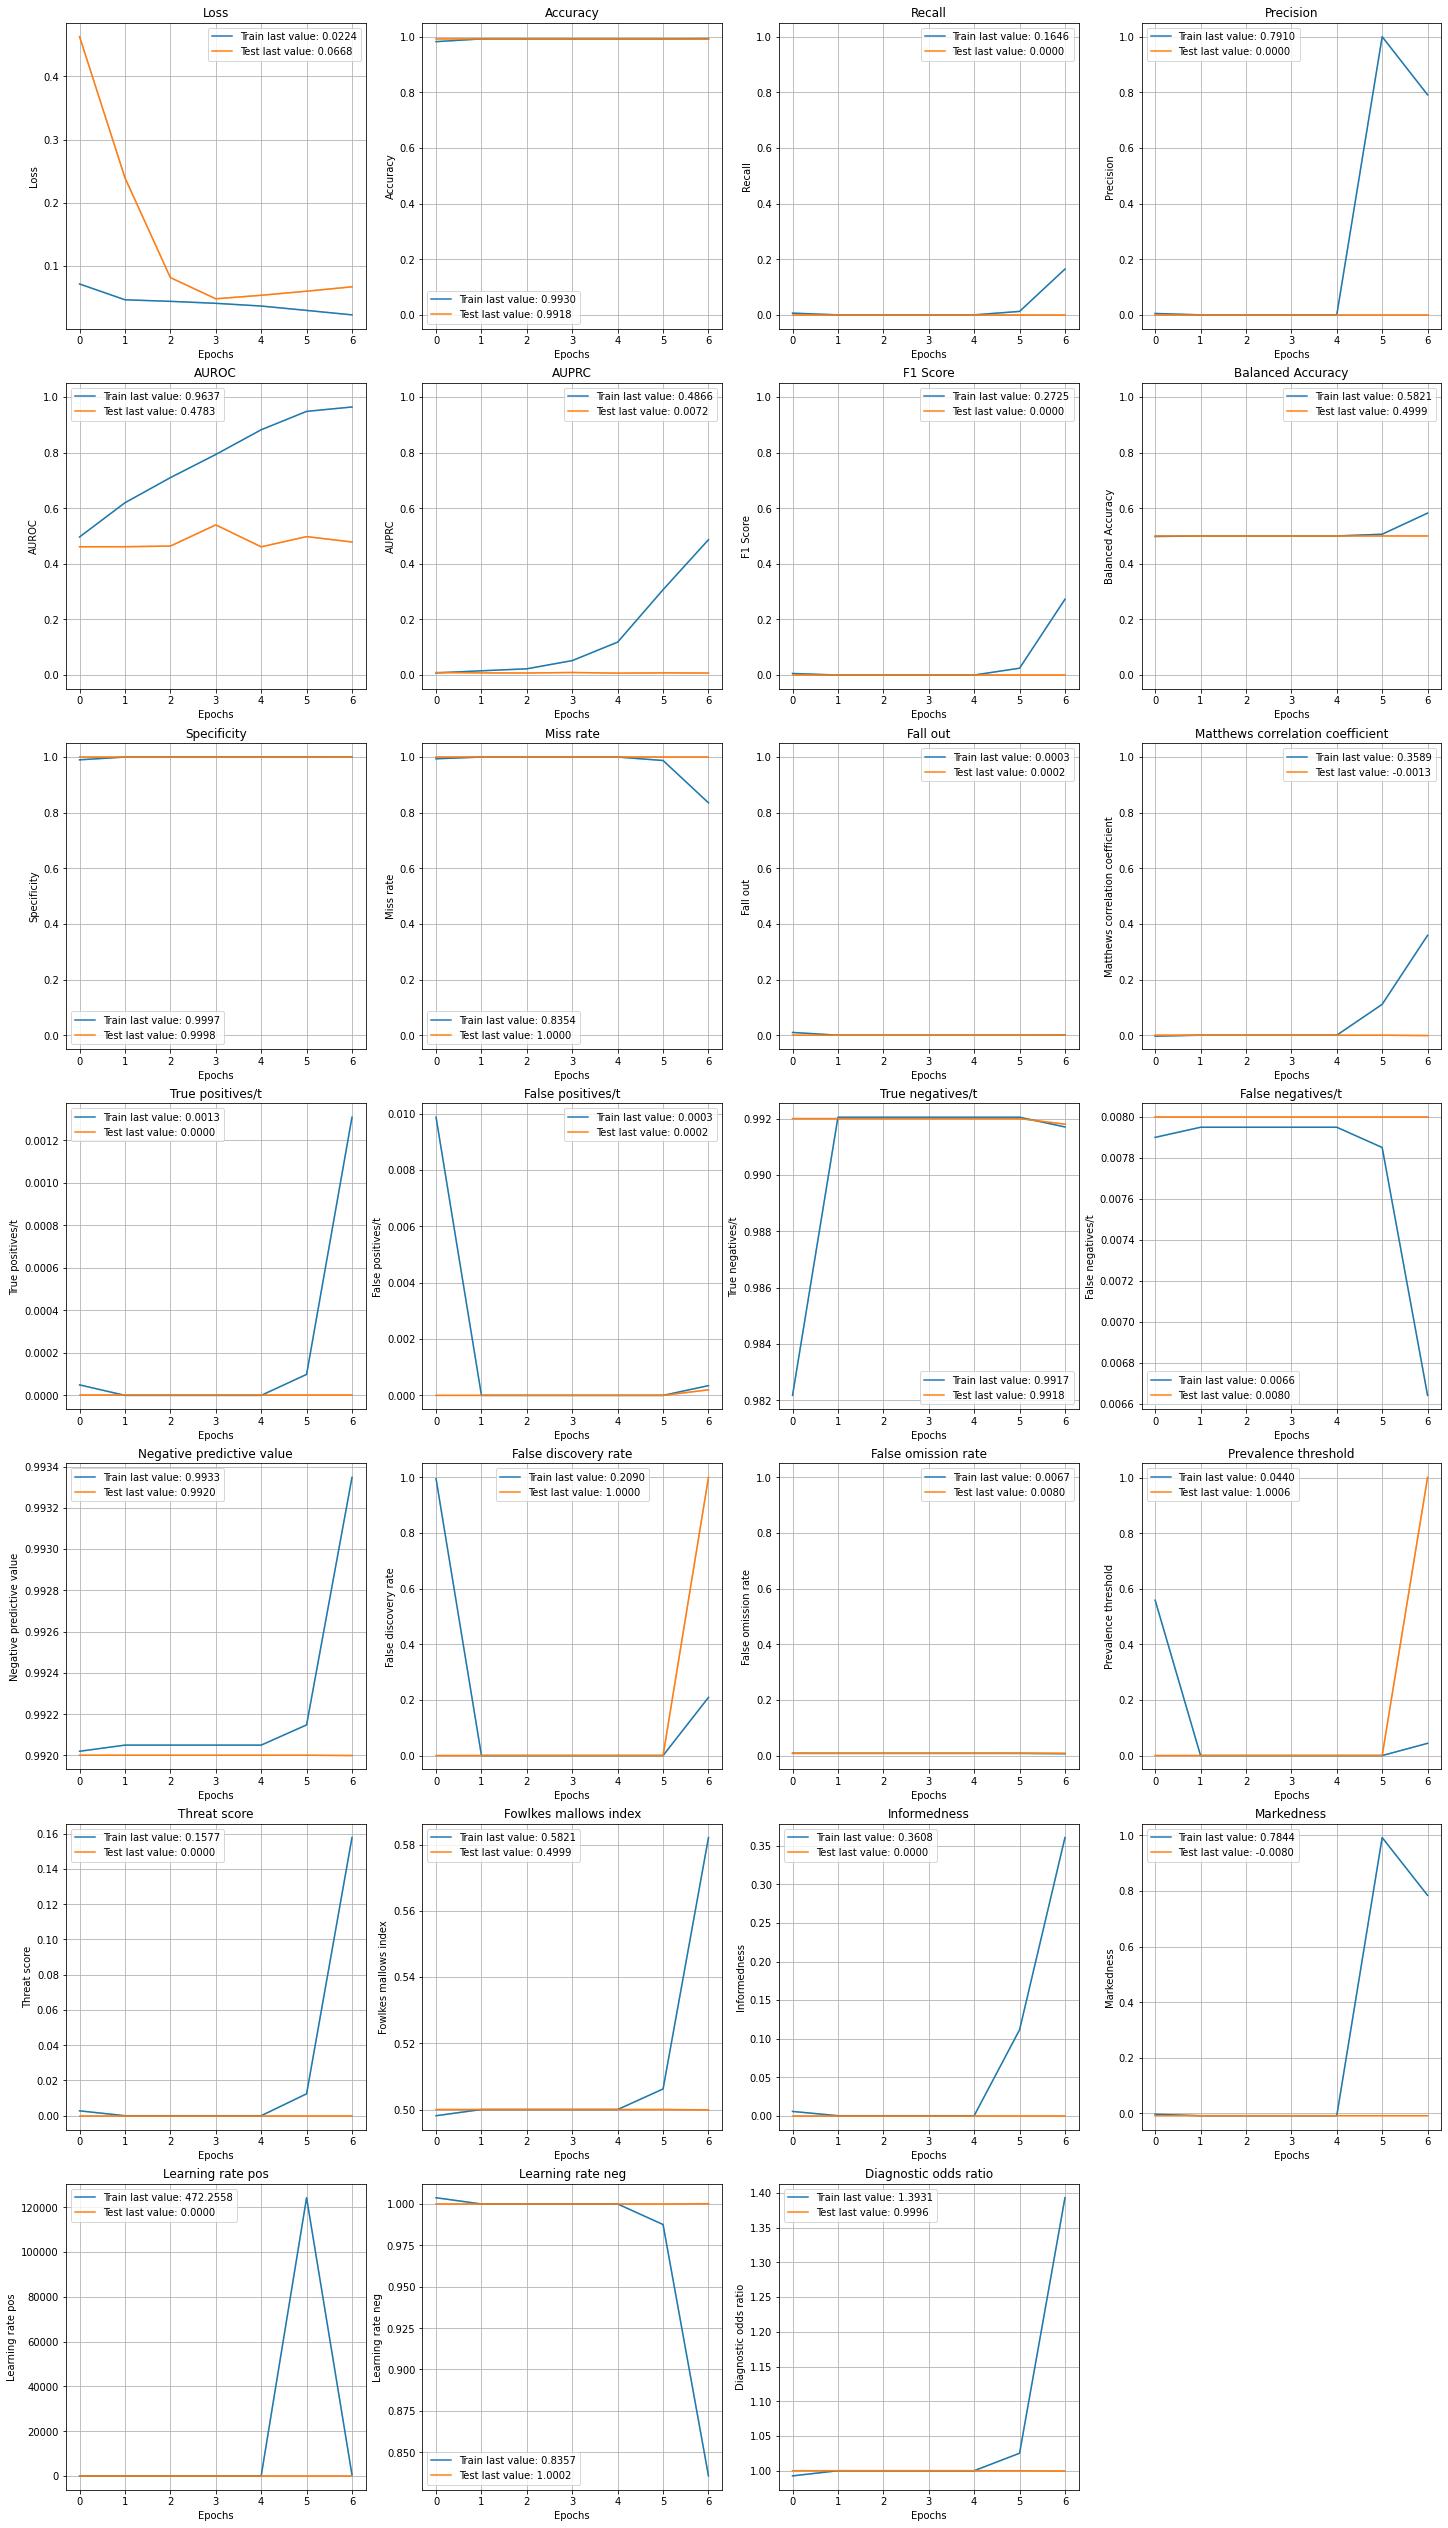

In [10]:
plot_history(results["enhancers"]["histories"][0])

# Results

In [8]:
enhancers_results = pd.read_csv("enhancers_results.csv")

In [11]:
enhancers_results[(enhancers_results["model_name"] == "cnn1d") & (enhancers_results["run_type"] == "test")]

Unnamed: 0      loss  accuracy  recall  precision     AUROC     AUPRC  \
1            1  0.060924   0.99202     0.0        0.0  0.602848  0.011991   
3            1  0.069495   0.99202     0.0        0.0  0.534668  0.010003   
5            1  0.079167   0.99202     0.0        0.0  0.515804  0.008909   
7            1  0.072644   0.99202     0.0        0.0  0.472555  0.007038   
9            1  0.072315   0.99202     0.0        0.0  0.521435  0.009011   
11           1  0.061977   0.99202     0.0        0.0  0.644726  0.020501   
13           1  0.072361   0.99202     0.0        0.0  0.460299  0.006876   
15           1  0.073766   0.99202     0.0        0.0  0.415438  0.006258   
17           1  0.071748   0.99202     0.0        0.0  0.488256  0.008146   
19           1  0.103353   0.99202     0.0        0.0  0.499044  0.007900   
21           1  0.083386   0.99202     0.0        0.0  0.573524  0.009588   
23           1  0.086263   0.99202     0.0        0.0  0.493947  0.007643   
25           1  0.083318   0.99202     0.0        0.0  0.504661  0.008685   
27           1  0.070444   0.99202     0.0        0.0  0.494759  0.008325   
29           1  0.077094   0.99202     0.0        0.0  0.496695  0.007766   
31           1  0.072325   0.99202     0.0        0.0  0.510216  0.008681   
33           1  0.092195   0.99202     0.0        0.0  0.540180  0.008551   
35           1  0.077200   0.99202     0.0        0.0  0.294012  0.005132   
37           1  0.083962   0.99202     0.0        0.0  0.494505  0.007666   
39           1  0.077757   0.99202     0.0        0.0  0.506748  0.008366   

    f1_score  balanced_accuracy  specificity  ...  model_name     region  \
1        0.0                0.5          1.0  ...       cnn1d  enhancers   
3        0.0                0.5          1.0  ...       cnn1d  enhancers   
5        0.0                0.5          1.0  ...       cnn1d  enhancers   
7        0.0                0.5          1.0  ...       cnn1d  enhancers   
9        0.0                0.5          1.0  ...       cnn1d  enhancers   
11       0.0                0.5          1.0  ...       cnn1d  enhancers   
13       0.0                0.5          1.0  ...       cnn1d  enhancers   
15       0.0                0.5          1.0  ...       cnn1d  enhancers   
17       0.0                0.5          1.0  ...       cnn1d  enhancers   
19       0.0                0.5          1.0  ...       cnn1d  enhancers   
21       0.0                0.5          1.0  ...       cnn1d  enhancers   
23       0.0                0.5          1.0  ...       cnn1d  enhancers   
25       0.0                0.5          1.0  ...       cnn1d  enhancers   
27       0.0                0.5          1.0  ...       cnn1d  enhancers   
29       0.0                0.5          1.0  ...       cnn1d  enhancers   
31       0.0                0.5          1.0  ...       cnn1d  enhancers   
33       0.0                0.5          1.0  ...       cnn1d  enhancers   
35       0.0                0.5          1.0  ...       cnn1d  enhancers   
37       0.0                0.5          1.0  ...       cnn1d  enhancers   
39       0.0                0.5          1.0  ...       cnn1d  enhancers   

    holdout_number  use_feature_selection  use_validation_set  patience  \
1                0                   True                True         3   
3                0                  False                True         3   
5                1                   True                True         3   
7                1                  False                True         3   
9                2                   True                True         3   
11               2                  False                True         3   
13               3                   True                True         3   
15               3                  False                True         3   
17               4                   True                True         3   
19               4                  Fal

## Results visualization

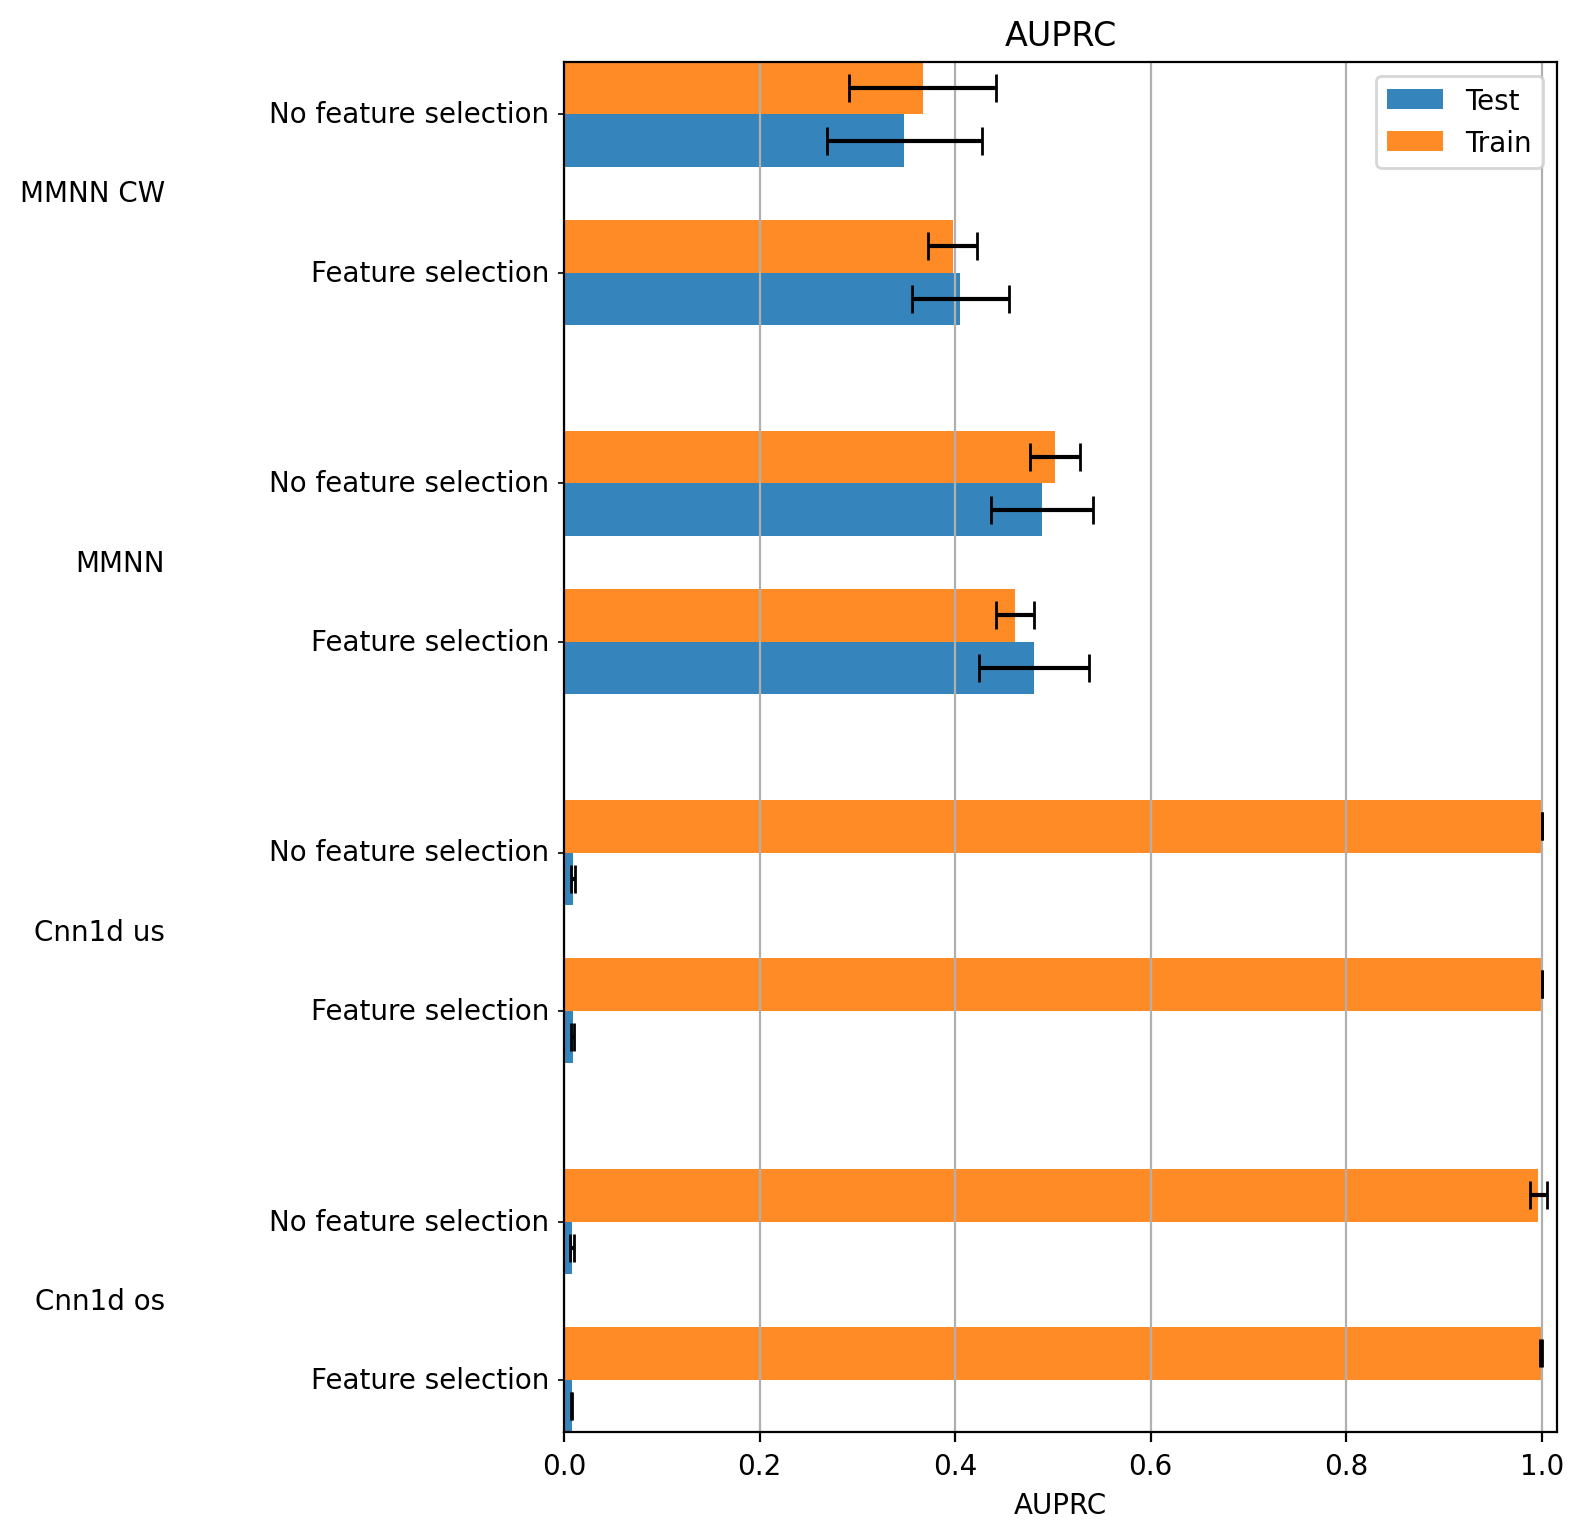

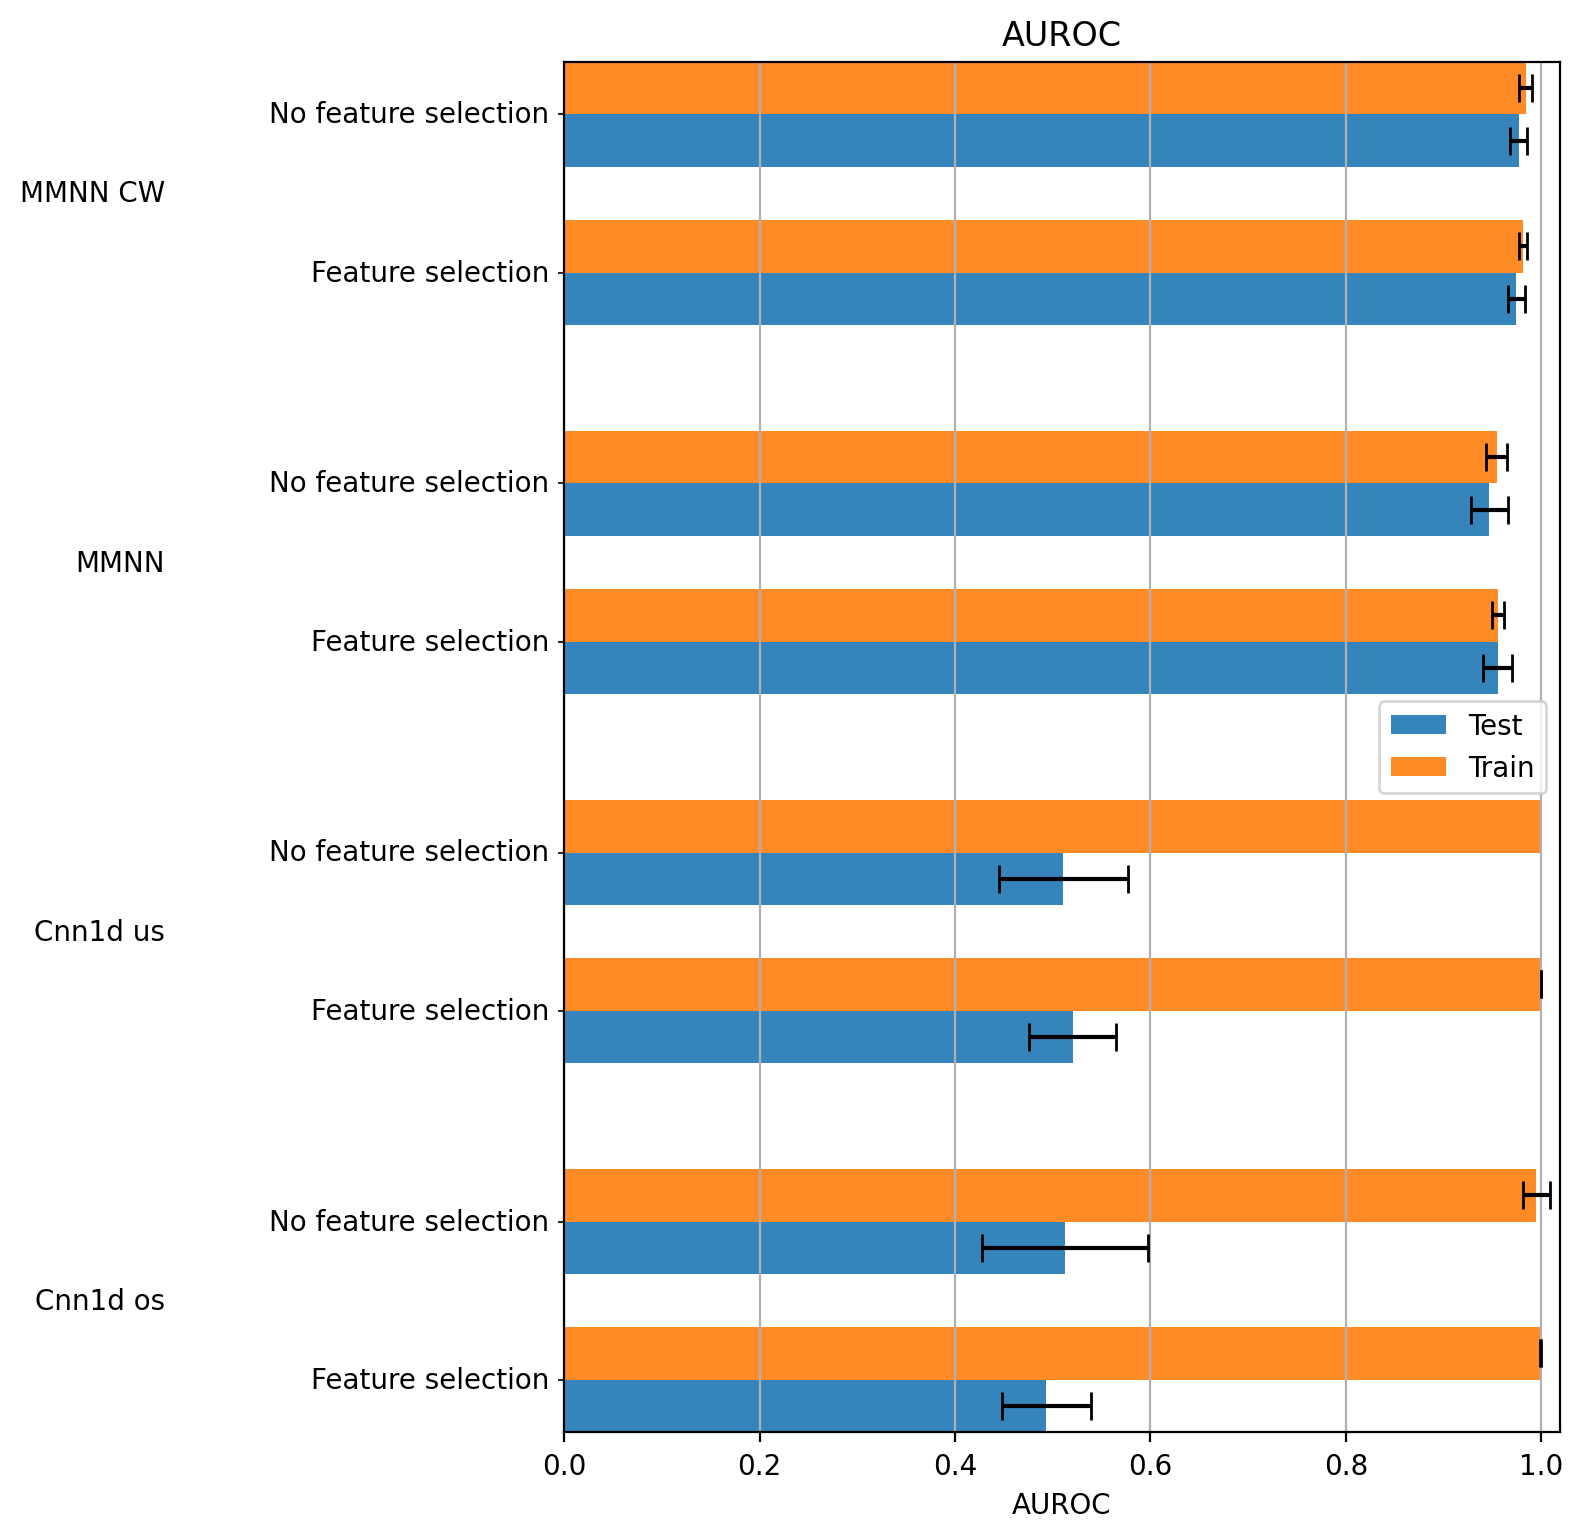

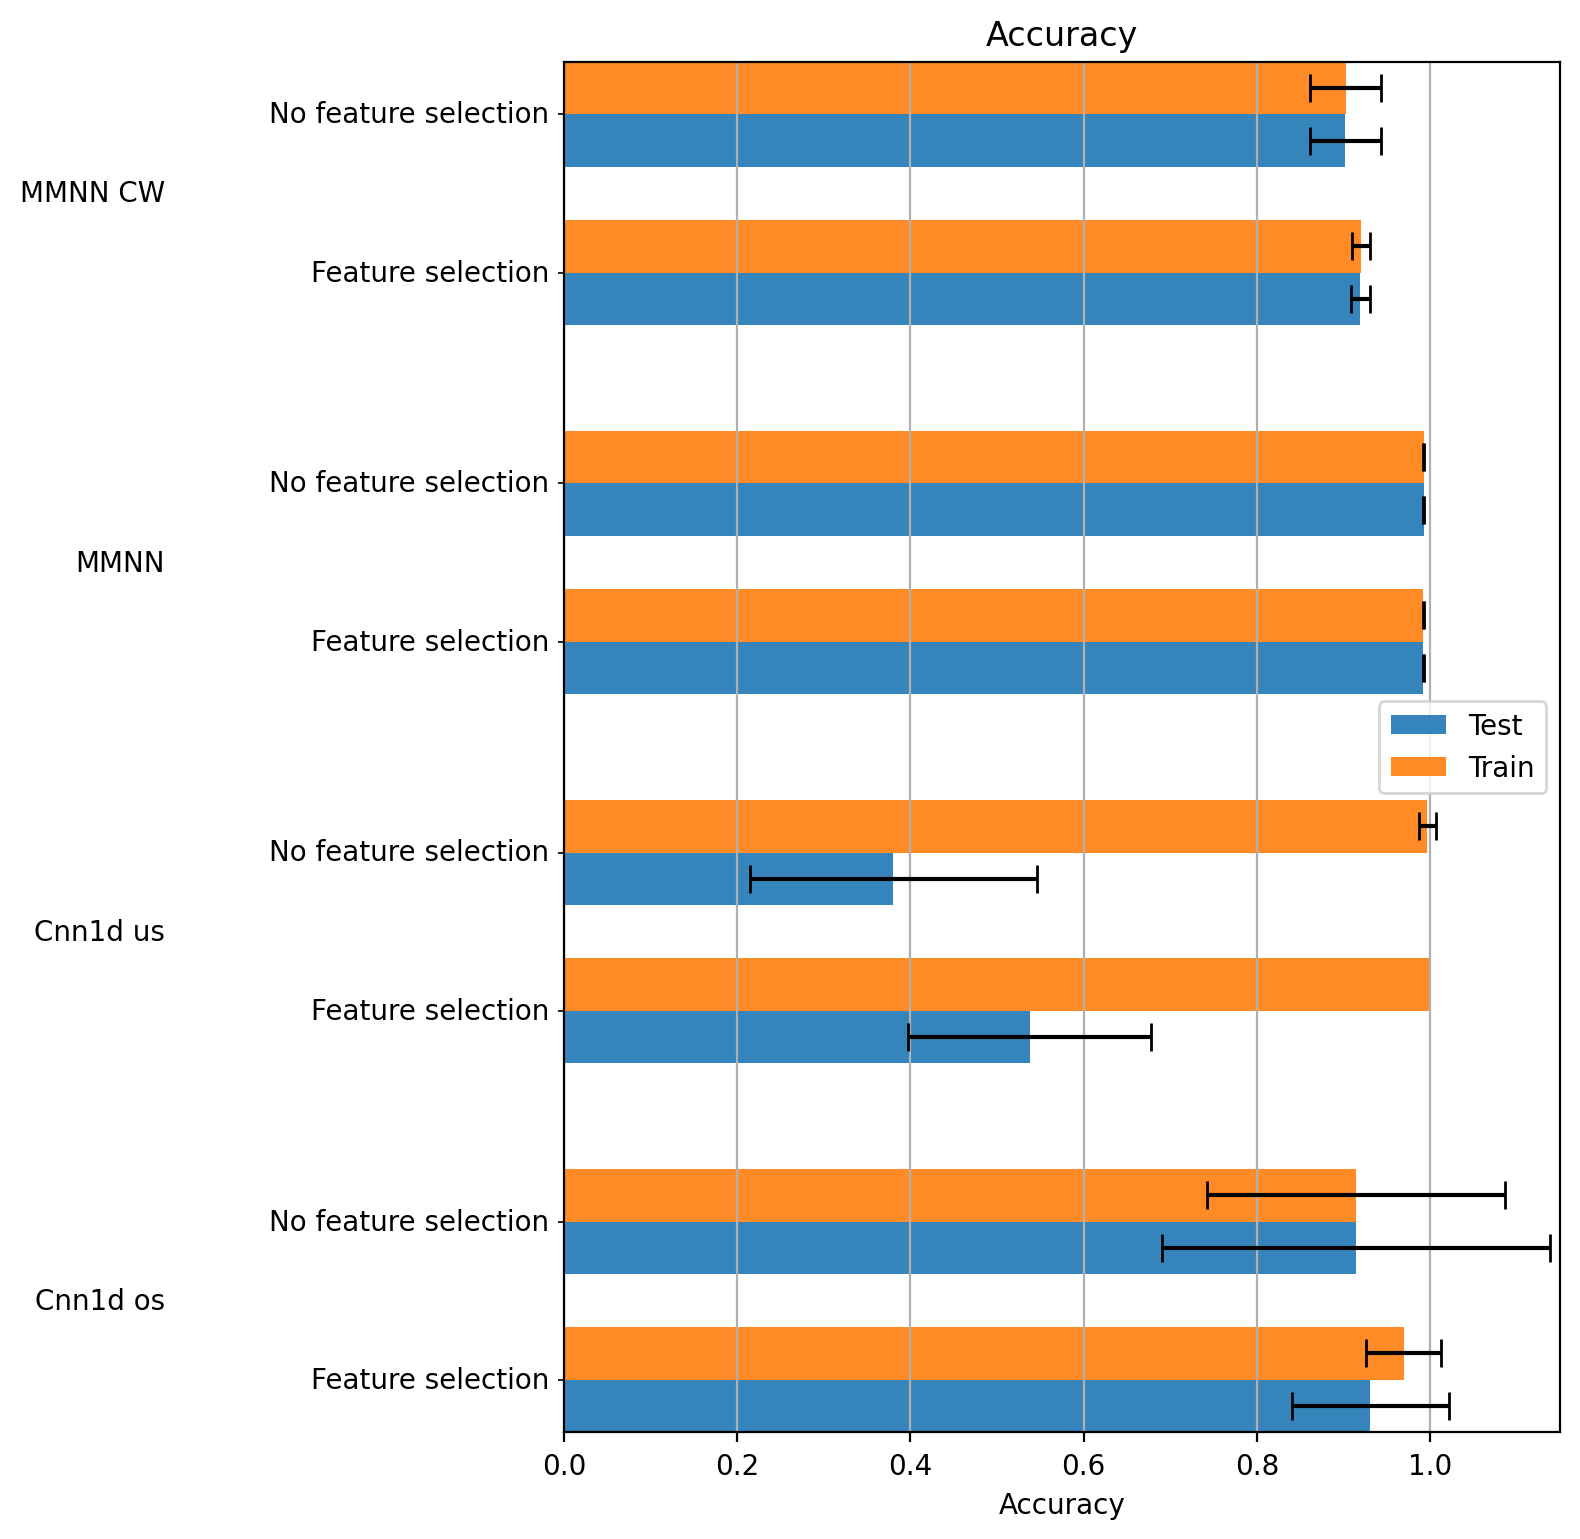

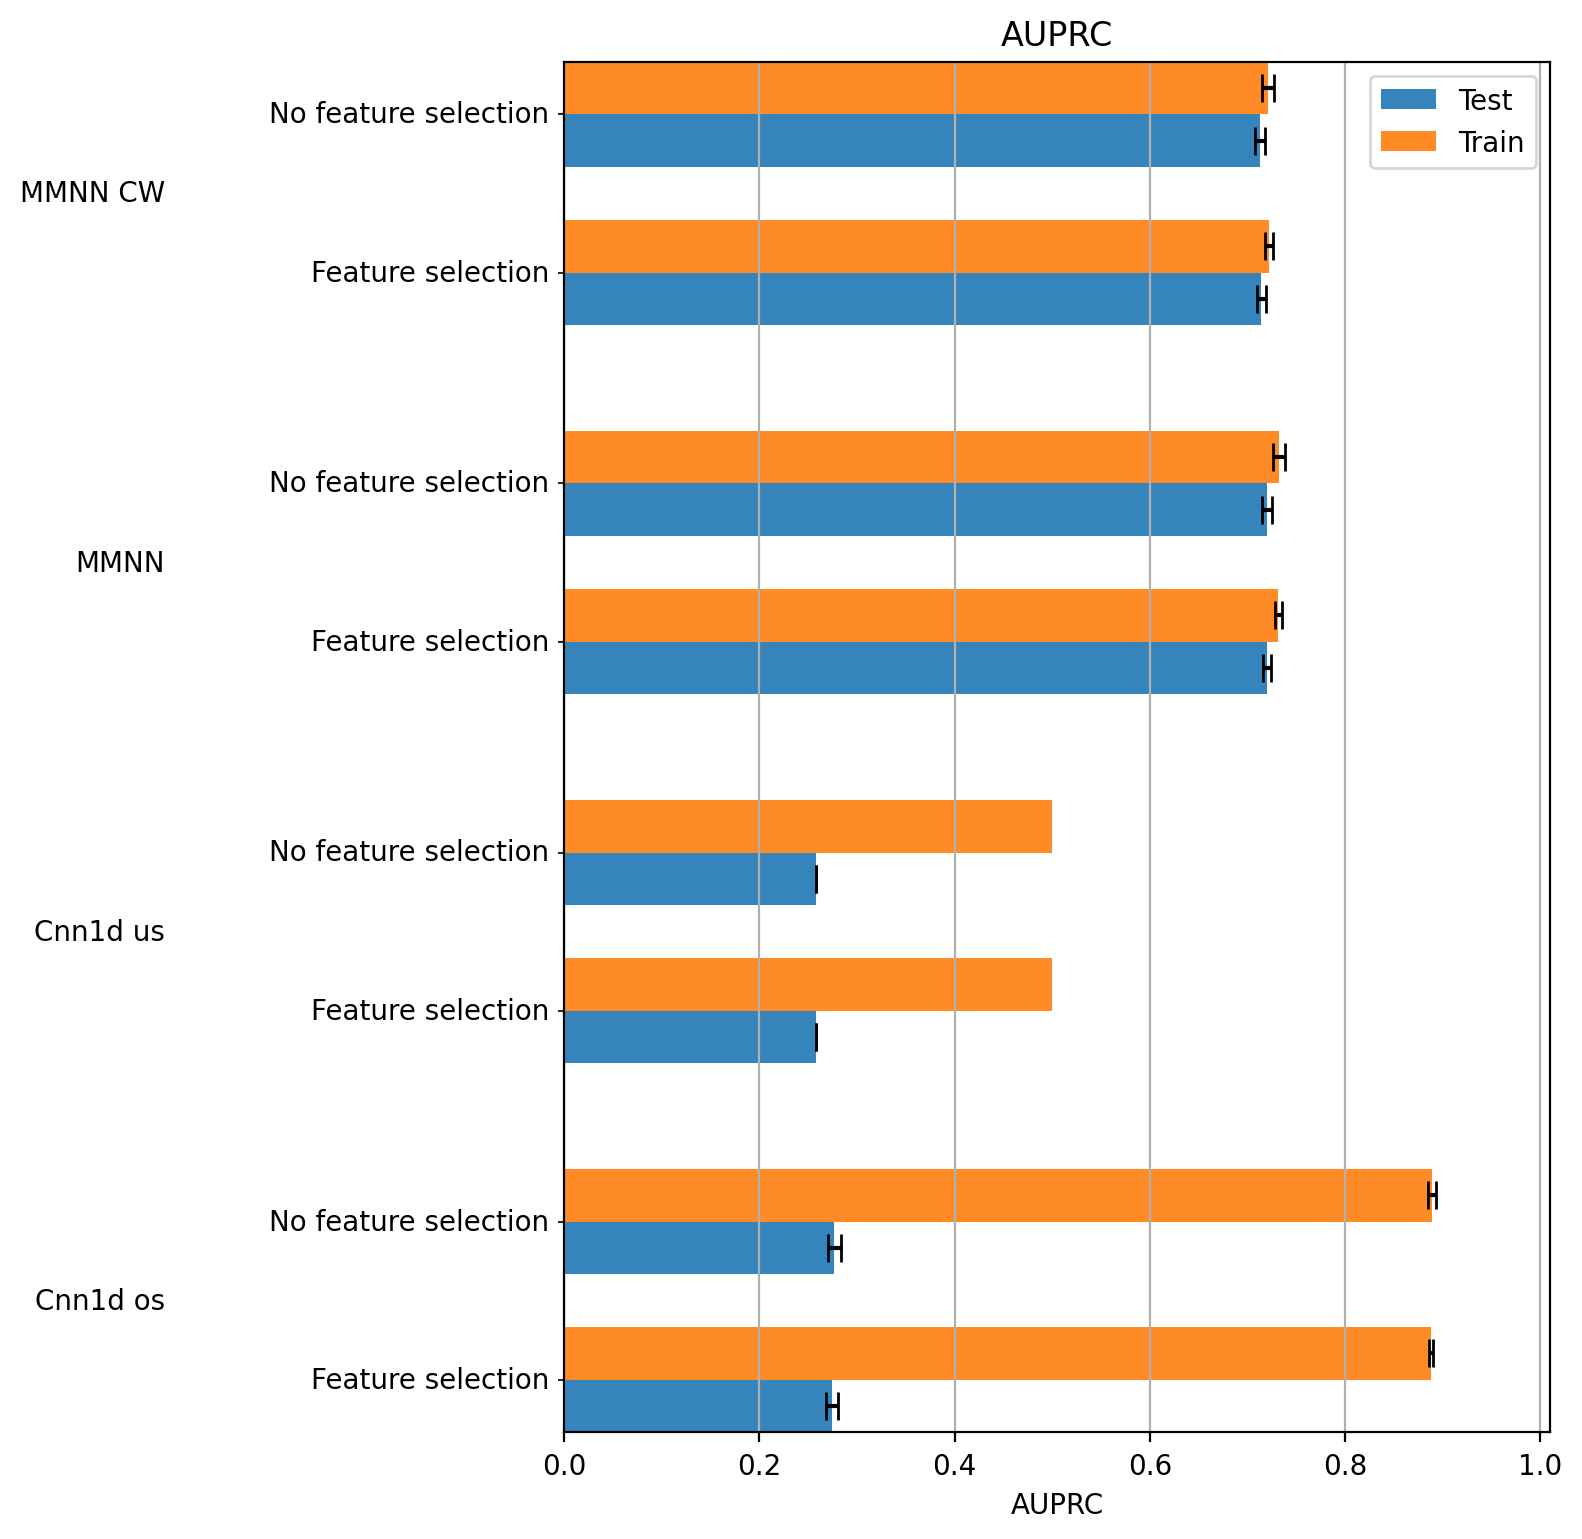

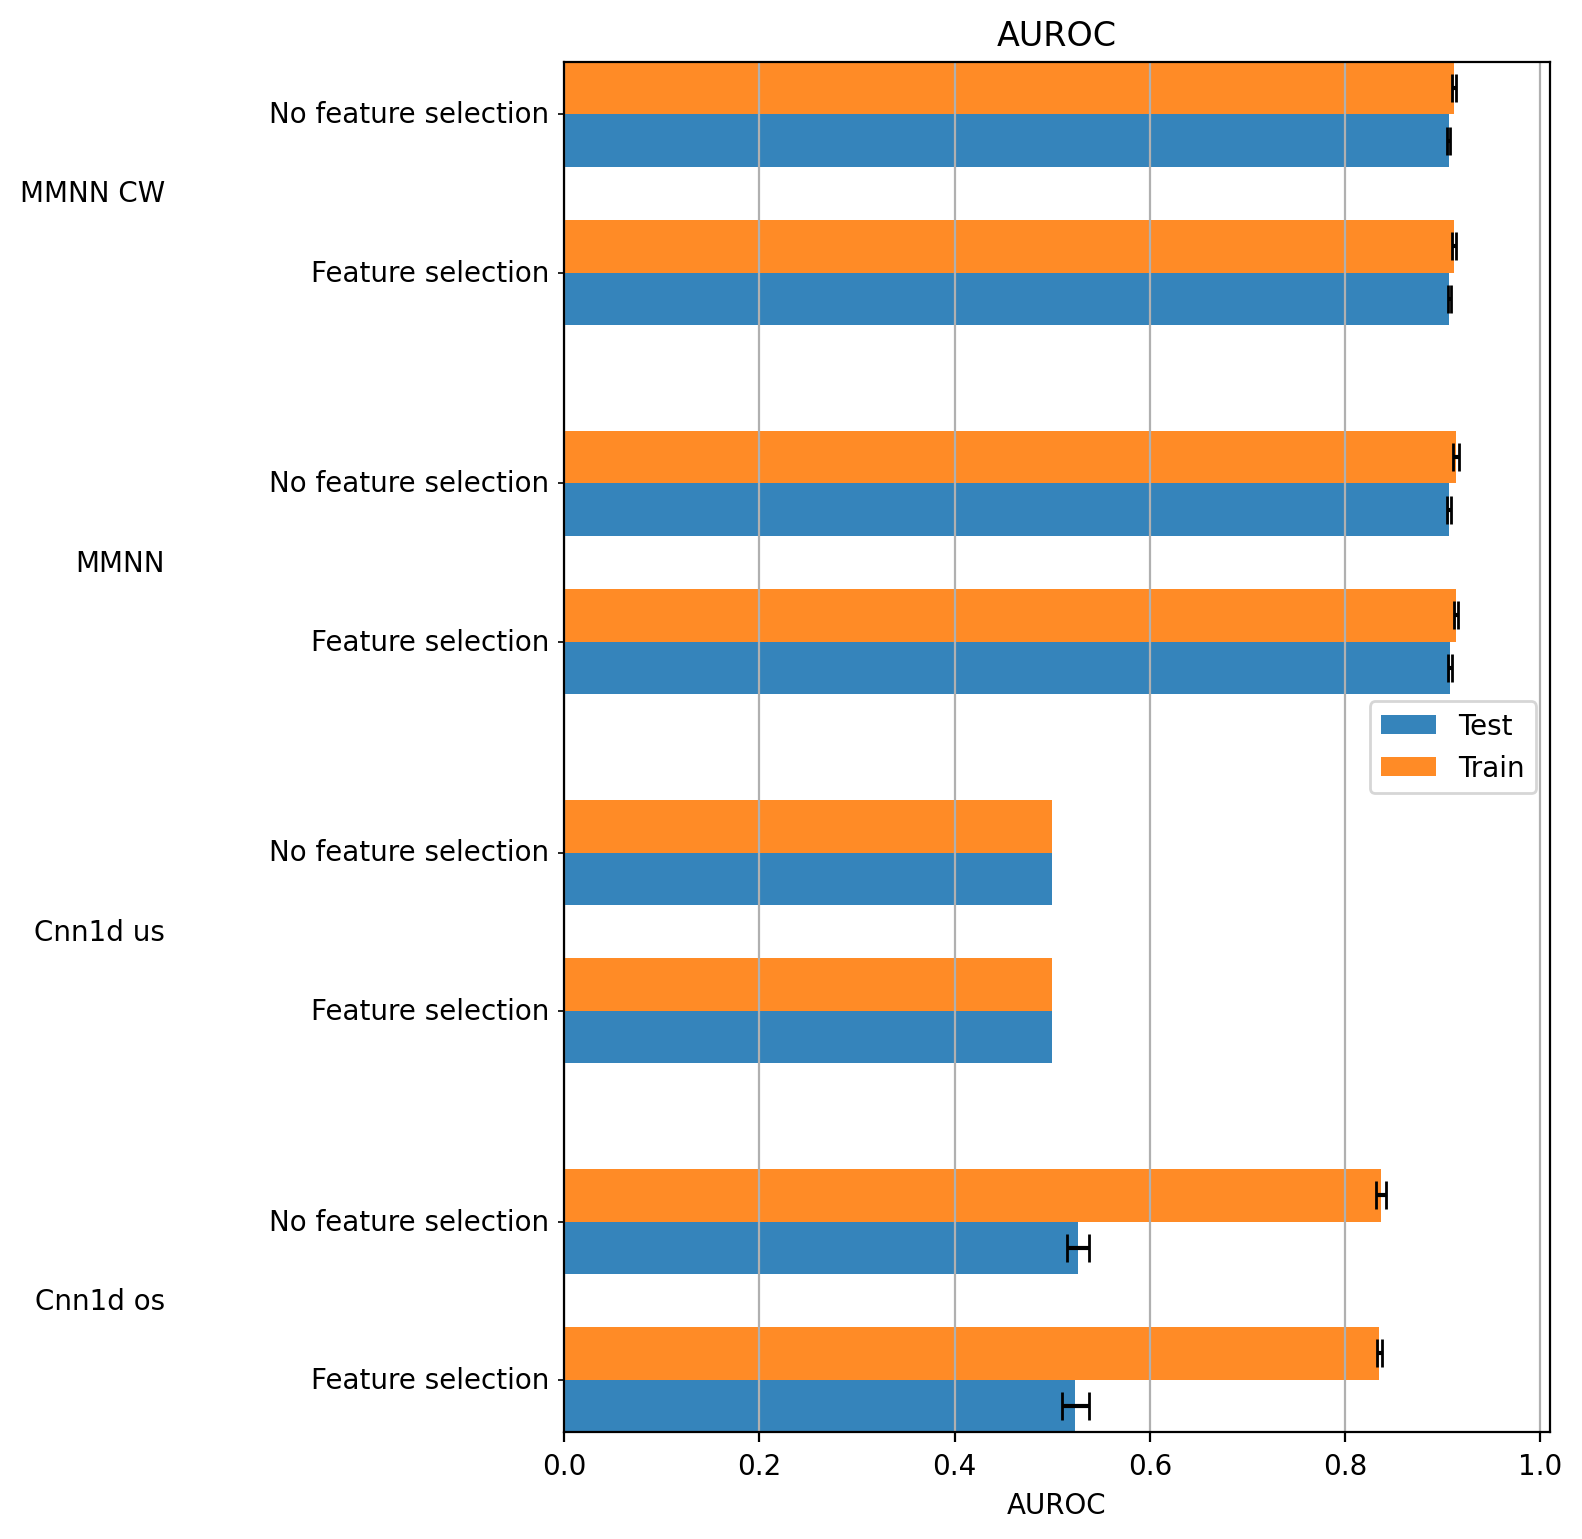

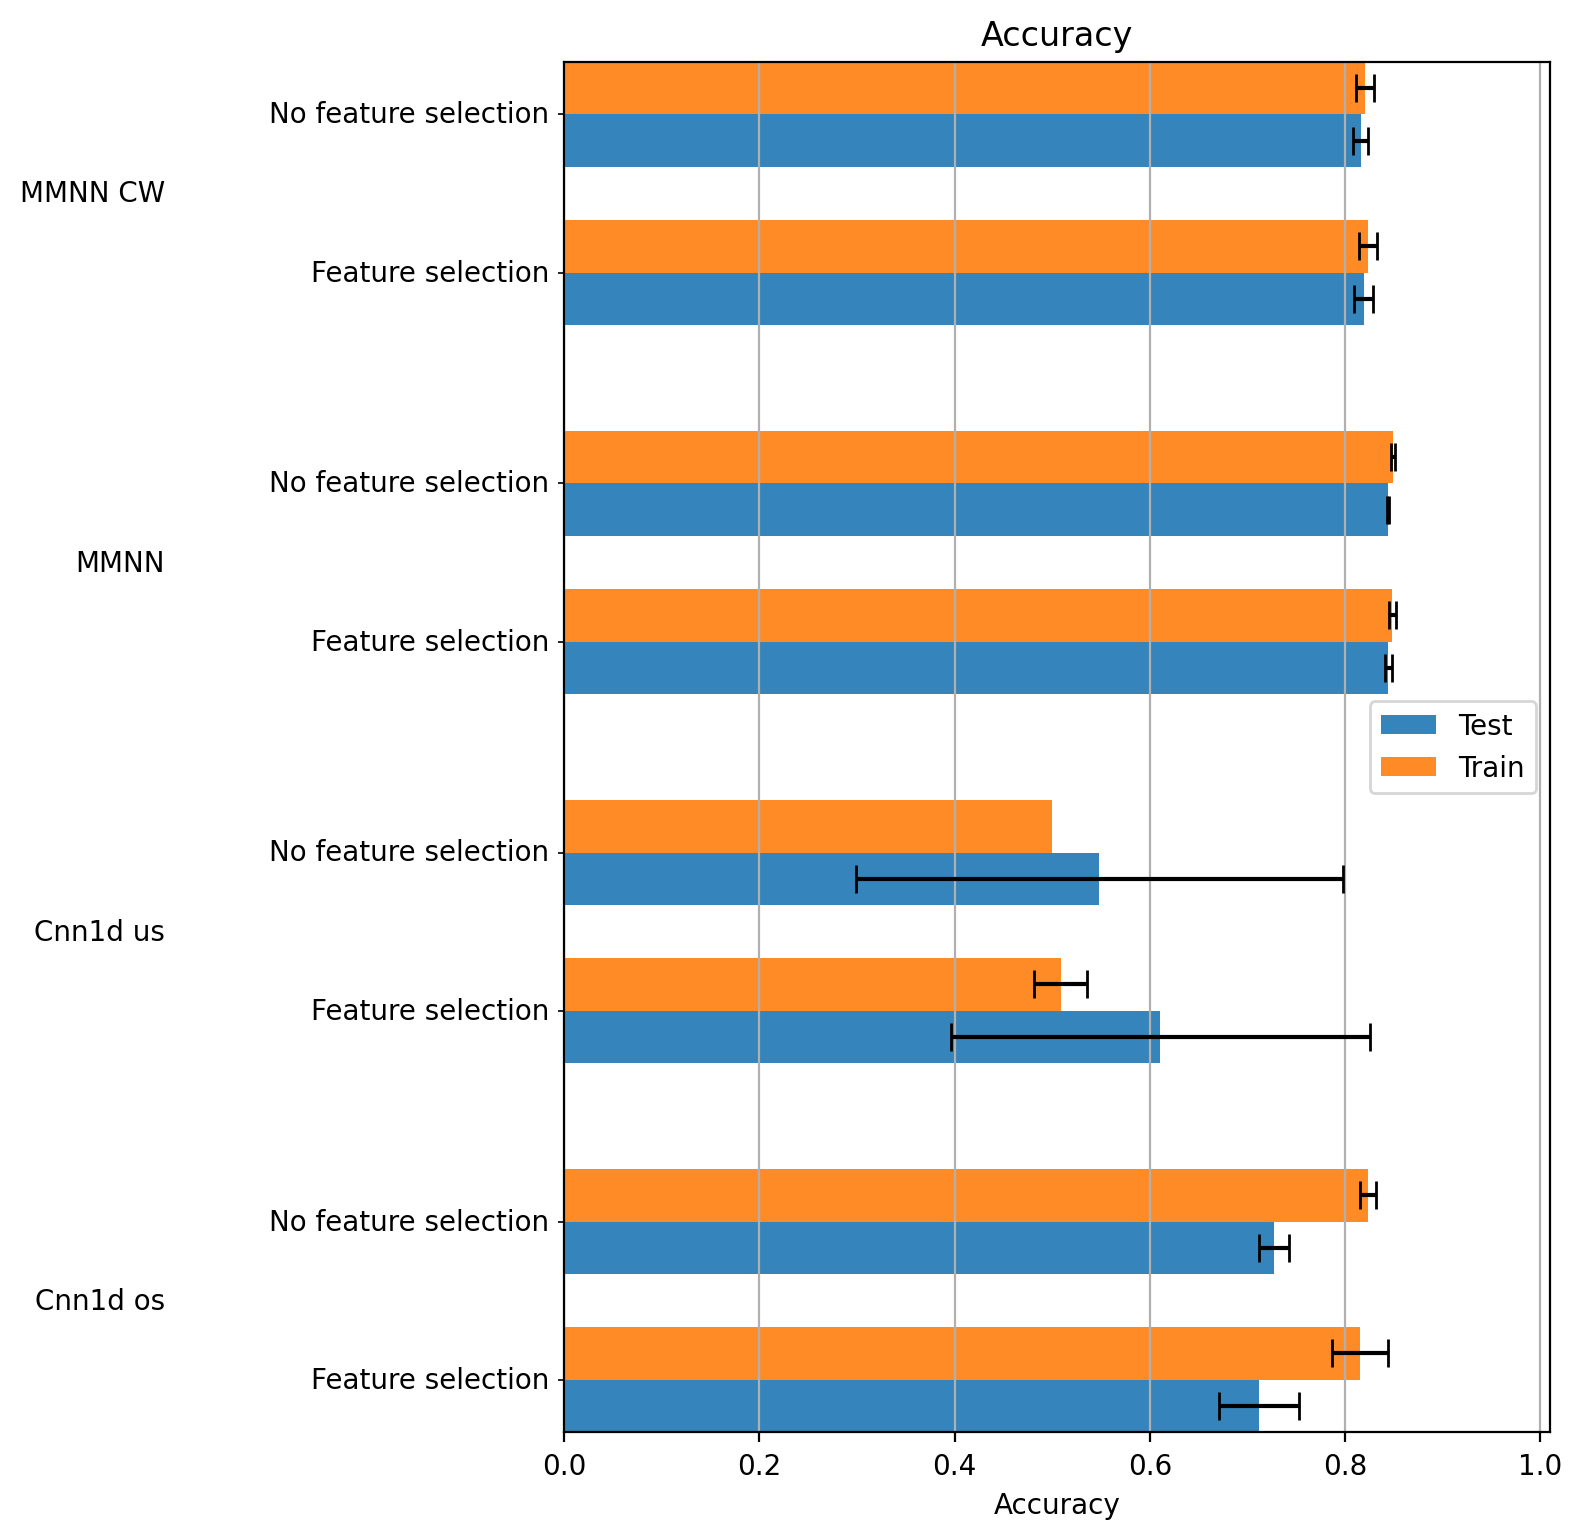

In [9]:
for region in ("enhancers", "promoters"):
    all_performances = pd.concat(results[region]["performances"])
    
    all_performances["use_feature_selection"] = [
        "Feature selection" if use_selection else "No feature selection"
        for use_selection in all_performances["use_feature_selection"]
    ]
    all_performances = all_performances.drop(
        columns=[
            "holdout_number", "loss", "recall", "precision", "f1_score",
            "balanced_accuracy", "specificity", "miss_rate", 
            "use_validation_set", "patience", "max_epochs", 
            "resampling_strategy", "class_weights", "window_size",
            "fall_out", "mcc", "tp/t", "fp/t", "tn/t", "fn/t",
            "negative_predictive_value", "threat_score", 
            "fowlkes_mallows_index", "informedness", "markedness",
            "LR_pos", "LR_neg", "DOR", "false_discovery_rate",
            "false_omission_rate", "prevalence_threshold"
        ]
    )
    
    barplots(
        all_performances,
        groupby=["region", "model_name", "use_feature_selection", "run_type"],
        orientation="horizontal",
        height=8
    )

## Feature selection relevance

In [14]:
for region in ("enhancers", "promoters"):
    all_performances = pd.concat(results[region]["performances"])
    
    for model in all_performances.model_name.unique():
        model_performance = all_performances[
            (all_performances.model_name == model) & 
            (all_performances.run_type == "test")
        ]

        performance_with_feature_selection = model_performance[
            model_performance.use_feature_selection == True
        ]

        performance_without_feature_selection = model_performance[
            model_performance.use_feature_selection == False
        ]

        for metric in ("AUPRC", "AUROC", "accuracy"):
            try:
                stat, pvalue = wilcoxon(
                    performance_with_feature_selection[metric], 
                    performance_without_feature_selection[metric]
                )
                
                print(
                    region,
                    model, 
                    metric, 
                    pvalue,
                    "different" if pvalue < 0.01 else "not different"
                )
            except ValueError:
                print(region, model, metric, "same value for all the elements")

enhancers ffnn_hp AUPRC WilcoxonResult(statistic=17.0, pvalue=0.5146697234497355)
enhancers ffnn_hp AUROC WilcoxonResult(statistic=22.0, pvalue=0.9527650219907529)
enhancers ffnn_hp accuracy WilcoxonResult(statistic=10.0, pvalue=0.26144605232963014)
enhancers cnn1d_hp AUPRC WilcoxonResult(statistic=24.0, pvalue=0.76953125)
enhancers cnn1d_hp AUROC WilcoxonResult(statistic=23.0, pvalue=0.6953125)
enhancers cnn1d_hp accuracy WilcoxonResult(statistic=3.0, pvalue=1.0)
enhancers bayesian_ffnn AUPRC WilcoxonResult(statistic=1.0, pvalue=0.00390625)
enhancers bayesian_ffnn AUROC WilcoxonResult(statistic=1.0, pvalue=0.00390625)
enhancers bayesian_ffnn accuracy WilcoxonResult(statistic=4.0, pvalue=0.013671875)
enhancers deep_enhancer AUPRC WilcoxonResult(statistic=20.0, pvalue=0.4921875)
enhancers deep_enhancer AUROC WilcoxonResult(statistic=24.0, pvalue=0.76953125)
enhancers deep_enhancer accuracy WilcoxonResult(statistic=10.0, pvalue=0.2626182904425206)
enhancers bayesian_cnn AUPRC WilcoxonRes

D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
D:\Users\gabri\anaconda3\envs\tf_p3.9\

## Models comparison

In [15]:
for region in ("enhancers", "promoters"):
    all_performances = pd.concat(results[region]["performances"])
    
    for first_model in all_performances.model_name.unique():
        first_model_performance = all_performances[
                (all_performances.model_name == first_model) &
                (all_performances.run_type == "test") &
                (all_performances.use_feature_selection == True)
        ]

        for second_model in all_performances.model_name.unique():
            if first_model >= second_model:
                continue
            second_model_performance = all_performances[
                (all_performances.model_name == second_model) &
                (all_performances.run_type == "test") &
                (all_performances.use_feature_selection == True)
            ]

            for metric in ("AUPRC", "AUROC", "accuracy"):
                first_perf = first_model_performance[metric]
                second_perf = second_model_performance[metric]
                _, p_value = wilcoxon(first_perf, second_perf)
                if p_value < 0.01:
                    if first_perf.mean() > second_perf.mean():
                        best_model, worse_model = first_model, second_model
                    else:
                        best_model, worse_model = second_model, first_model
                    print(
                        "[{}] The model {} outperforms the model {} with p-value {} on metric {}.".
                          format(region, best_model, worse_model, p_value, metric)
                    )
                else:
                    print(
                        "[{}] The model {} is statistically indistinguishable from {} with p-value {} on metric {}."
                          .format(region, first_model, second_model, p_value, metric)
                    )

[enhancers] The model ffnn_hp outperforms the model cnn1d_hp with p-value 0.001953125 on metric AUPRC.
[enhancers] The model ffnn_hp outperforms the model cnn1d_hp with p-value 0.001953125 on metric AUROC.
[enhancers] The model cnn1d_hp is statistically indistinguishable from ffnn_hp with p-value 0.011616044899262472 on metric accuracy.
[enhancers] The model cnn1d_hp is statistically indistinguishable from deep_enhancer with p-value 0.193359375 on metric AUPRC.
[enhancers] The model cnn1d_hp is statistically indistinguishable from deep_enhancer with p-value 0.431640625 on metric AUROC.
[enhancers] The model cnn1d_hp is statistically indistinguishable from deep_enhancer with p-value 0.916511907863894 on metric accuracy.
[enhancers] The model cnn1d_hp is statistically indistinguishable from deepcape with p-value 0.064453125 on metric AUPRC.
[enhancers] The model cnn1d_hp is statistically indistinguishable from deepcape with p-value 1.0 on metric AUROC.
[enhancers] The model cnn1d_hp is s

D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
D:\Users\gabri\anaconda3\envs\tf_p3.9\